In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats 
import scipy.integrate as integrate
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import datetime
import seaborn as sns
import pystan as ps
import multiprocessing
multiprocessing.set_start_method("fork", force=True)
import arviz as az
from sklearn.linear_model import LinearRegression

sns.set()
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = [15, 10]

In [2]:
# data
deis=pd.read_csv('data/deis_2020_enero2021_covid.csv', sep=';') # https://deis.minsal.cl/#datosabiertos
deis.fecha=pd.to_datetime(deis.fecha,format = '%Y-%m-%d')
demo=pd.read_csv('data/ine_estimaciones-y-proyecciones-2002-2035_base-2017_region_base.csv')# https://www.ine.cl/docs/default-source/proyecciones-de-poblacion/cuadros-estadisticos/base-2017/ine_estimaciones-y-proyecciones-2002-2035_base-2017_region_base.csv?sfvrsn=1c01d705_8&download=true
# https://www.minciencia.gob.cl/COVID19
casos=pd.read_csv('../../Datos-COVID19/output/producto3/CasosTotalesCumulativo.csv')
hospi=pd.read_csv('../../Datos-COVID19/output/producto22/HospitalizadosEtario_Acumulado.csv')

In [3]:
deisAll = deis[((deis['año']==2020) | (deis['año']==2021))  & (deis['causa'].str.contains('COVID-19'))]

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
deisAll = deisAll[deisAll['fecha']<=pd.to_datetime('2021-01-10')]

In [5]:
first_death=deisAll.sort_values(by='fecha')['fecha'].iloc[0]
last_death=deisAll.sort_values(by='fecha')['fecha'].iloc[-1]

In [6]:
print('Date of the first Covid-19 death:', first_death)
print('Date of the last Covid-19 death:', last_death)

Date of the first Covid-19 death: 2020-03-16 00:00:00
Date of the last Covid-19 death: 2021-01-10 00:00:00


In [7]:
deathsAllCauses = deis[(deis['fecha']>=first_death) & (deis['fecha']<=last_death)]

In [8]:
# age group
ageInterval=list(range(0,85,5))
ageInterval.append(130)

In [9]:
# standardization of labels
demo20=demo.loc[:,['Region','Sexo','Edad','a2020']]
demo20['age-group']=pd.cut(x=demo20['Edad'], bins=ageInterval, right=False)
demoGrouped=demo20.drop(columns='Edad').groupby(['Region','Sexo','age-group']).sum().reset_index()
demoGrouped=demoGrouped.rename(columns={'Region':'region','Sexo':'sex','a2020':'y2020'})
demoGrouped['sex']=demoGrouped['sex'].replace(1,'Male')
demoGrouped['sex']=demoGrouped['sex'].replace(2,'Female')

In [10]:
# standardization of labels
labels=['fecha', 'genero', 'edad', 'region','causa']
deisAll=deisAll[labels]
deisAll=deisAll.rename(columns={'fecha':'date', 'genero':'sex', 'edad':'age', 'causa':'cause'})
deisAll['sex']=deisAll['sex'].replace('Hombre','Male')
deisAll['sex']=deisAll['sex'].replace('Mujer','Female')
deisAll['cause']=deisAll['cause'].replace('COVID-19 virus no identificado','suspicious')
deisAll['cause']=deisAll['cause'].replace('COVID-19 virus identificado','confirmed')
# grouping by 5-year age group 
deisAll['age-group']=pd.cut(x=deisAll['age'], bins=ageInterval, right=False)

In [11]:
#time=np.sort(deisAll.date.unique())

In [12]:
dicRegion2={'Arica y Parinacota':15, 'Tarapacá':1, 'Antofagasta':2, 'Atacama':3,
       'Coquimbo':4, 'Valparaíso':5, 'Metropolitana':13, 'O’Higgins':6, 'Maule':7,
       'Ñuble':16, 'Biobío':8, 'Araucanía':9, 'Los Ríos':14, 'Los Lagos':10, 'Aysén':11,
       'Magallanes':12, 'Total':17}
invDicRegion2={v: k for k, v in dicRegion2.items()}

In [13]:
listAge=[]
for i in range(17):
    listAge.append(deisAll['age-group'].unique()[17-i-1])

In [14]:
# Dictionary between region number and region name
dicRegion={'Del Maule':7, 'Metropolitana de Santiago':13, 'De Antofagasta':2,
       'De Valparaíso':5, 'De Atacama':3, 'De Los Ríos':14, 'De Coquimbo':4,
       'Del Bíobío':8, "Del Libertador B. O'Higgins":6, 'De Ñuble':16,
       'De Tarapacá':1, 'De Arica y Parinacota':15, 'De La Araucanía':9,
       'De Magallanes y de La Antártica Chilena':12, 'De Los Lagos':10,
       'De Aisén del Gral. C. Ibáñez del Campo':11, 'Ignorada':17}
invDicRegion = {v: k for k, v in dicRegion.items()}

In [15]:
deisAll=deisAll.replace(dicRegion)

Text(0.5, 1.0, 'Covid-19 deaths in Chile')

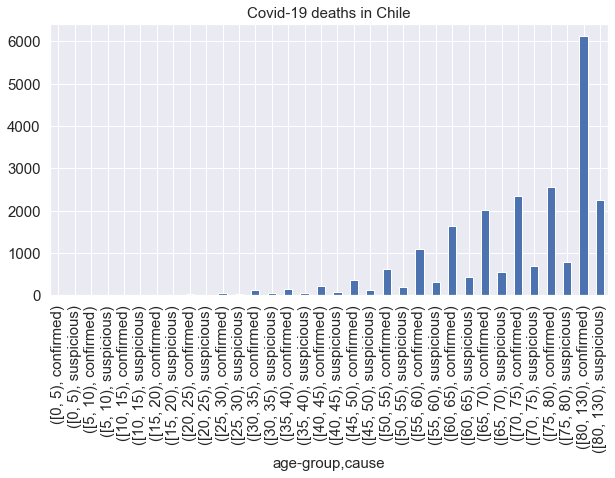

In [16]:
fig, ax =plt.subplots(1,figsize=(10,5))
deisAll.groupby(['age-group','cause']).count().plot.bar(y='date',ax=ax, rot=90, legend=False)
ax.set_title('Covid-19 deaths in Chile')

In [17]:
print('Median age of covid-19 deaths: ', deisAll['age'].median())
print('Average age of covid-19 deaths: ', deisAll['age'].mean())

Median age of covid-19 deaths:  75.0
Average age of covid-19 deaths:  73.09129696547521


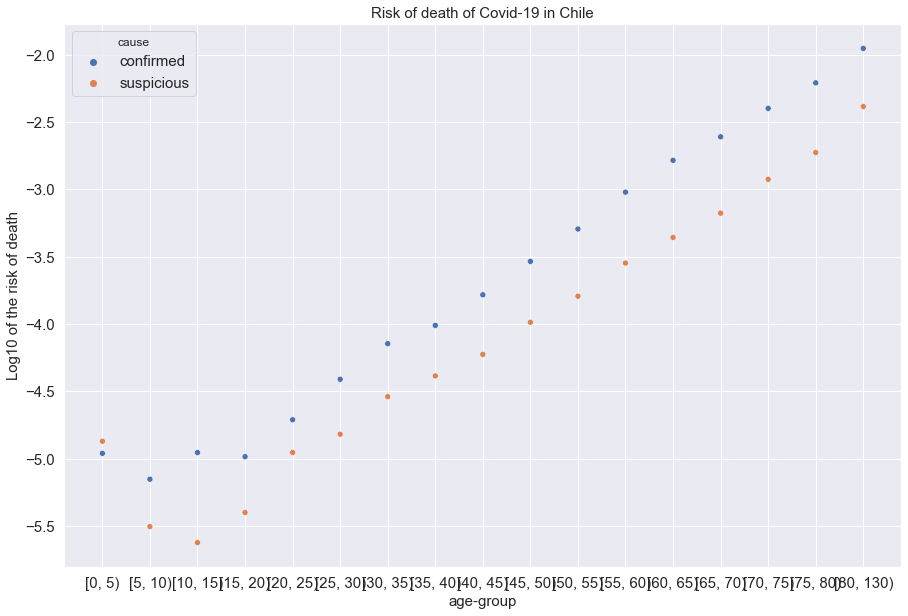

In [18]:
fig, ax =plt.subplots(1,figsize=(15,10))
risk=pd.DataFrame(deisAll.groupby(['age-group','cause']).count().region/demoGrouped.groupby(['age-group']).sum().y2020).rename(columns={0:'chile'}).reset_index()
#riskConf=risk[risk['cause']=='confirmed'].drop(columns='cause')
#risk[['chile']]=risk[['chile']].divide(risk[risk['age-group']==pd.Interval(50,55,closed='left')][['chile']].values, axis=1)
risk['log']=risk['chile'].apply(lambda x: np.log(x)/np.log(10))
risk['age-group']=risk['age-group'].astype(str)
sns.scatterplot(x='age-group',y='log', hue='cause', data=risk)
plt.title('Risk of death of Covid-19 in Chile')
plt.ylabel('Log10 of the risk of death')
fig.savefig('figures/risk_deaths_chile.png')

In [19]:
death_regionAll=deisAll[deisAll.region!=17].groupby(['age-group','region','cause']).count().date.reset_index()
risk_region=deisAll[deisAll.region!=17].groupby(['age-group','region','cause']).count().date.divide(demoGrouped.groupby(['age-group','region']).sum().y2020).reset_index().rename(columns={0:'risk_death'})
risk_region['risk_death']=risk_region['risk_death'].apply(lambda x: np.log(x)/np.log(10))

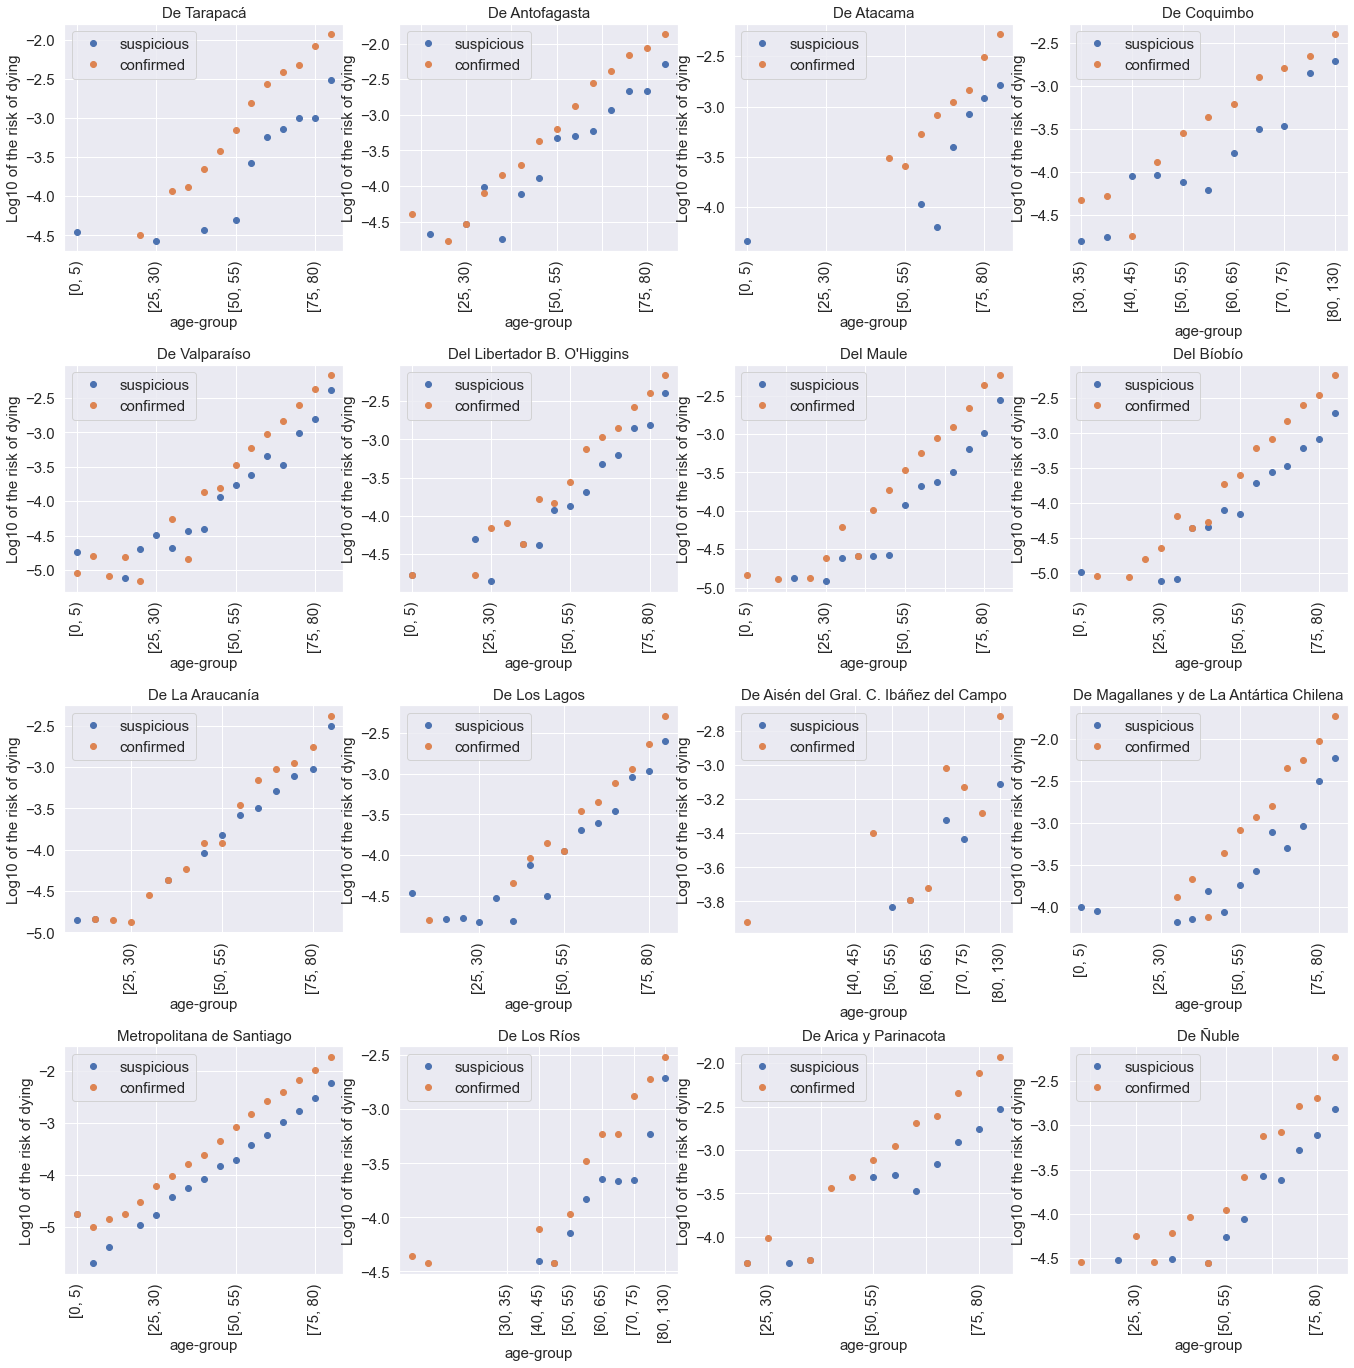

In [20]:
fig, ax =plt.subplots(4,4,figsize=(23,23))
for i in death_regionAll.region.unique():
    j=(i-1)//4
    k=(i-1)%4
    risk_region[(risk_region.region==i) & (risk_region.cause=='suspicious')].plot(x='age-group',y='risk_death',  ax=ax[j,k], label='suspicious',  style='o',rot=90)
    risk_region[(risk_region.region==i) & (risk_region.cause=='confirmed')].plot(x='age-group',y='risk_death', ax=ax[j,k], label='confirmed', style='o',rot=90)
    ax[j,k].title.set_text(invDicRegion[i])
    ax[j,k].set_ylabel('Log10 of the risk of dying')
fig.subplots_adjust(hspace=0.5)
fig.savefig('figures/risk_deaths.png')

## Comparison covid-19 pcr confirmed deaths, covid-19 deaths, excess mortality

In [21]:
dicRegion3={'Arica y Parinacota': 15,
 'Tarapacá': 1,
 'Antofagasta': 2,
 'Atacama': 3,
 'Coquimbo': 4,
 'Valparaíso': 5,
 'Metropolitana de Santiago': 13,
 "Libertador General Bernardo O'Higgins": 6,
 'Maule': 7,
 'Ñuble': 16,
 'Biobío': 8,
 'La Araucanía': 9,
 'Los Ríos': 14,
 'Los Lagos': 10,
 'Aysén del General Carlos Ibáñez del Campo': 11,
 'Magallanes y de la Antártica Chilena': 12}

In [22]:
i=0
selectDeaths = (deis[(deis['fecha']>=first_death.replace(year=2016+i)) & (deis['fecha']<=last_death.replace(year=2016+i+1))].groupby('region').count()[['fecha']]).rename(columns={'fecha':2016+i})
for i in range(1,5):
    selectDeaths = pd.merge(selectDeaths, deis[(deis['fecha']>=first_death.replace(year=2016+i)) & (deis['fecha']<=last_death.replace(year=2016+i+1))].groupby('region').count()[['fecha']].rename(columns={'fecha':2016+i}), left_index=True, right_index=True)
selectDeaths.loc['Chile'] = selectDeaths.sum(axis=0).values
selectDeaths['excessDeath'] = selectDeaths[2020] - selectDeaths[[2016,2017,2018,2019]].median(axis=1)
selectDeaths = selectDeaths.reset_index()
selectDeaths['region'] = selectDeaths['region'].replace(dicRegion).replace(invDicRegion2)
selectDeaths = selectDeaths[['region', 'excessDeath']]
selectDeaths = selectDeaths.set_index('region')

In [23]:
# mortality excess by region
compDeaths=deisAll[deisAll.cause=='confirmed'].groupby('region').count().date.reset_index().rename(columns={'date':'DEIS PCR confirmed deaths (CD)'})
compDeaths['DEIS all COVID-19 deaths (AD)']=deisAll.groupby('region').count().date.reset_index().date
compDeaths = compDeaths.replace(invDicRegion2)
compDeaths = compDeaths.set_index('region')
compDeaths=pd.merge(compDeaths,selectDeaths, left_index=True, right_index=True)
compDeaths.loc['Chile'] = compDeaths.sum(axis=0).values

In [24]:
print('Excess mortality:', compDeaths.loc['Chile','excessDeath']/deathsAllCauses.count()['fecha']*100, '%')

Excess mortality: 17.156341582922703 %


In [25]:
print(compDeaths.to_latex(index=True))

\begin{tabular}{lllr}
\toprule
{} & DEIS PCR confirmed deaths (CD) & DEIS all COVID-19 deaths (AD) &  excessDeath \\
region             &                                &                               &              \\
\midrule
Tarapacá           &                            309 &                           368 &        332.5 \\
Antofagasta        &                            600 &                           800 &        602.5 \\
Atacama            &                            117 &                           152 &         97.0 \\
Coquimbo           &                            315 &                           441 &        371.5 \\
Valparaíso         &                           1303 &                          1912 &       1600.5 \\
O’Higgins          &                            618 &                           916 &        768.0 \\
Maule              &                            627 &                           841 &        677.5 \\
Biobío             &                            917 &     

# PyStan model for bayesian inference

In [26]:
# we assume that the infection fatality rate by age and by sex is a uniform random variable with bounds adapted from https://www.nature.com/articles/s41586-020-2918-0
# see p.22 Supplementary Information (https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2918-0/MediaObjects/41586_2020_2918_MOESM1_ESM.pdf)
ifr=demoGrouped[demoGrouped['sex']=='Male'].groupby('age-group').sum().drop(columns='y2020').rename(columns={'region':'ifr_m'})
#ifr['ifr_m']=np.array([0.003, 0.001, 0.001, 0.003, 0.008, 0.017, 0.033, 0.056, 0.106, 0.168, 0.291, 0.448, 0.595, 1.452, 2.307, 4.260, 10.825])*1e-2
ifr['ifr_m_low']=np.array([0.002, 0.00001, 0.001, 0.002, 0.007, 0.014, 0.028, 0.048, 0.091, 0.144, 0.250, 0.384, 0.511, 1.244, 1.976, 3.651, 9.276])*1e-2
ifr['ifr_m_up']=np.array([0.004,0.001, 0.002, 0.003,0.009, 0.020,0.038,0.065,0.123,0.195, 0.336, 0.518, 0.688, 1.680, 2.668, 4.929,12.523])*1e-2

#ifr['ifr_f']=np.array([0.003, 0.001, 0.001, 0.002, 0.005, 0.009, 0.015, 0.025, 0.044, 0.073, 0.123, 0.197,0.318, 0.698, 1.042, 2.145, 5.759])*1e-2
ifr['ifr_f_low']=np.array([0.002,0.00001,0.00001, 0.002,0.004,0.008,0.013,0.021,0.038,0.063,0.105,0.169,0.273,0.598,0.893,1.838,4.935])*1e-2
ifr['ifr_f_up']=np.array([0.003,0.001,0.001,0.003,0.006,0.011,0.018,0.029,0.051,0.085,0.142,0.228,0.367,0.807,1.206,2.482,6.662])*1e-2

# I change a little bit  some  IFR prior because the model showed that the posterior of some IFRs moved a lot in a bound of the support.
ifr['ifr_m_low']=np.array([0.002, 0.00001, 0.001, 0.002, 0.007, 0.014, 0.028, 0.048, 0.091, 0.144, 0.250, 0.384, 0.511, 1.244, 1.976, 3.651, 8.276])*1e-2
ifr['ifr_m_up']=np.array([0.004,0.001, 0.002, 0.003,0.009, 0.020,0.038,0.065,0.123,0.195, 0.436, 0.8, 1.2, 2, 3, 5.329,12.523])*1e-2
ifr['ifr_m']=(ifr['ifr_m_up']+ifr['ifr_m_low'])/2
ifr['ifr_f_low']=np.array([0.002,0.00001,0.00001, 0.002,0.004,0.008,0.013,0.021,0.038,0.063,0.105,0.169,0.273,0.598,0.893,1.838,3.935])*1e-2 
ifr['ifr_f_up']=np.array([0.003,0.001,0.001,0.003,0.006,0.011,0.018,0.029,0.051,0.185,0.242,0.6,1,1.3,1.7,3,6.662])*1e-2
ifr['ifr_f']=(ifr['ifr_m_up']+ifr['ifr_m_low'])/2

# In the reference, we only have 95% credible intervals, the bounds of  uniform laws are deduced from them
ifr['ifr_m_low']=ifr['ifr_m_low']-(ifr['ifr_m_up']-ifr['ifr_m_low'])/95/2
ifr['ifr_m_up']=ifr['ifr_m_up']+(ifr['ifr_m_up']-ifr['ifr_m_low'])/95/2
ifr['ifr_f_low']=ifr['ifr_f_low']-(ifr['ifr_f_up']-ifr['ifr_f_low'])/95/2
ifr['ifr_f_up']=ifr['ifr_f_up']+(ifr['ifr_f_up']-ifr['ifr_f_low'])/95/2

<AxesSubplot:xlabel='age-group'>

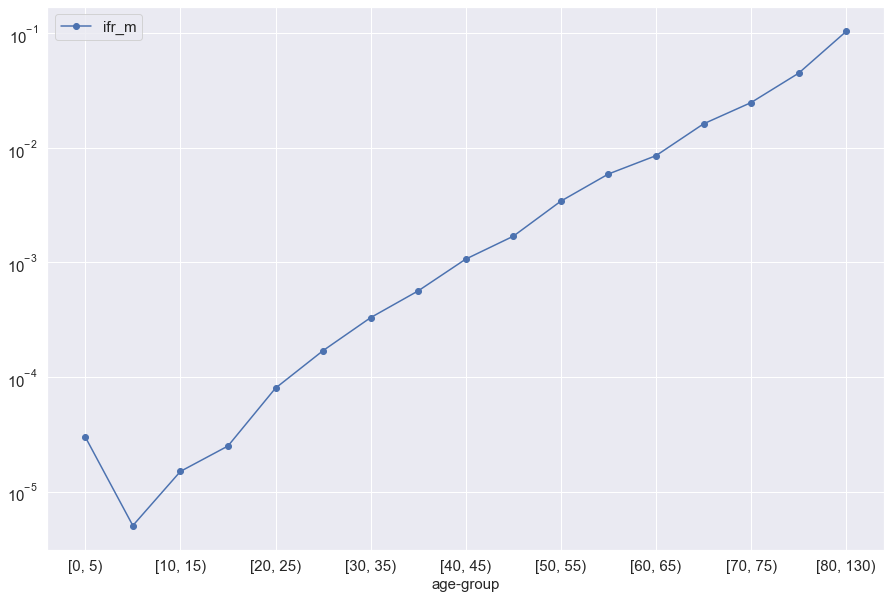

In [27]:
ifr.plot(y='ifr_m', use_index=True, logy=True, marker='o')

In [28]:
# number of age group : 17 for all ages, 13 for peaple less than 65 years
N_age=17;

In [29]:
ifr_m=ifr[['ifr_m_low','ifr_m_up']].values[0:N_age]
ifr_f=ifr[['ifr_f_low','ifr_f_up']].values[0:N_age]

In [30]:
deisMaleAll=deisAll[(deisAll['sex']=='Male')].groupby(['age-group','region']).count().fillna(0).reset_index()[['age-group','region','date']]
deisFemaleAll=deisAll[(deisAll['sex']=='Female')].groupby(['age-group','region']).count().fillna(0).reset_index()[['age-group','region','date']]

In [31]:
deis_m_regionAll = deisMaleAll.pivot_table(columns='region', index='age-group', values='date').reset_index()
deis_f_regionAll = deisFemaleAll.pivot_table(columns='region', index='age-group', values='date').reset_index()
deis_m_regionAll['total']=deis_m_regionAll.iloc[:,1:].sum(axis=1)
deis_f_regionAll['total']=deis_f_regionAll.iloc[:,1:].sum(axis=1)
# two male deaths in a region unkown
deis_m_regionAll=deis_m_regionAll.drop(columns=17)

In [32]:
# only confirmed deaths
deisMaleConf=deisAll[(deisAll['sex']=='Male')&(deisAll['cause']=='confirmed')].groupby(['age-group','region']).count().fillna(0).reset_index()[['age-group','region','date']]
deisFemaleConf=deisAll[(deisAll['sex']=='Female')&(deisAll['cause']=='confirmed')].groupby(['age-group','region']).count().fillna(0).reset_index()[['age-group','region','date']]
deis_m_regionConf = deisMaleConf.pivot_table(columns='region', index='age-group', values='date').reset_index()
deis_f_regionConf = deisFemaleConf.pivot_table(columns='region', index='age-group', values='date').reset_index()
deis_m_regionConf['total']=deis_m_regionConf.iloc[:,1:].sum(axis=1)
deis_f_regionConf['total']=deis_f_regionConf.iloc[:,1:].sum(axis=1)
# two male deaths in a region unkown
deis_m_regionConf=deis_m_regionConf.drop(columns=17)

In [33]:
# matrix of deaths by age (lines), in each regions (columns), last coloumn is total deaths in Chile
deaths_m_regionAll=deis_m_regionAll.iloc[:,1:].values.astype(int)[0:N_age,:]
deaths_f_regionAll=deis_f_regionAll.iloc[:,1:].values.astype(int)[0:N_age,:]
#only confirmed deaths
deaths_m_regionConf=deis_m_regionConf.iloc[:,1:].values.astype(int)[0:N_age,:]
deaths_f_regionConf=deis_f_regionConf.iloc[:,1:].values.astype(int)[0:N_age,:]

In [34]:
# population by age-group in all Chile
pop_m=demoGrouped[demoGrouped['sex']=='Male'].groupby('age-group').sum().y2020.values.astype(int)
pop_f=demoGrouped[demoGrouped['sex']=='Female'].groupby('age-group').sum().y2020.values.astype(int)

In [35]:
# population by age-group and by region
demoM_region=demoGrouped[demoGrouped['sex']=='Male'].groupby(['age-group','region']).sum().reset_index().pivot_table(columns='region', index='age-group', values='y2020').reset_index()
demoF_region=demoGrouped[demoGrouped['sex']=='Female'].groupby(['age-group','region']).sum().reset_index().pivot_table(columns='region', index='age-group', values='y2020').reset_index()

In [36]:
# adding a column for the total population by sex
demoM_region['total']=demoM_region.iloc[:,1:].sum(axis=1)
demoF_region['total']=demoF_region.iloc[:,1:].sum(axis=1)

In [37]:
# matrix of population by age (lines), in each regions (columns), last coloumn is total population in Chile
pop_m_region=demoM_region.iloc[:,1:].values.astype(int)[0:N_age,:]
pop_f_region=demoF_region.iloc[:,1:].values.astype(int)[0:N_age,:]

In [38]:
timeFirstToLastDeath = pd.date_range(start=first_death, end=last_death) # time from first death to last death
N_day = timeFirstToLastDeath.shape[0] # number of days from first days to last death

In [39]:
pd_ddeathsAll=deisAll.drop(columns='age-group').groupby(['region','date']).count().reset_index().sort_values('date').drop(columns='age').rename(columns={'sex':'deaths'})
pd_ddeathsAll=pd_ddeathsAll.pivot_table(columns='region', index='date', values='deaths').reset_index().fillna(0)
pd_ddeathsAll[17]=pd_ddeathsAll.iloc[:,1:17].sum(axis=1)
pd_ddeathsAll = pd.DataFrame(pd_ddeathsAll.set_index('date'), index=timeFirstToLastDeath).fillna(0)
ddeathsAll=pd_ddeathsAll.iloc[:,:].values.astype(int)# daily deaths
deathsTAll=ddeathsAll.sum(axis=0)

In [40]:
pd_ddeathsConf=deisAll[deisAll['cause']=='confirmed'].drop(columns='age-group').groupby(['region','date']).count().reset_index().sort_values('date').drop(columns='age').rename(columns={'sex':'deaths'})
pd_ddeathsConf=pd_ddeathsConf.pivot_table(columns='region', index='date', values='deaths').reset_index().fillna(0)
pd_ddeathsConf[17]=pd_ddeathsConf.iloc[:,1:17].sum(axis=1)
pd_ddeathsConf = pd.DataFrame(pd_ddeathsConf.set_index('date'), index=timeFirstToLastDeath).fillna(0)
ddeathsConf=pd_ddeathsConf.iloc[:,:].values.astype(int)# daily deaths
deathsTConf=ddeathsConf.sum(axis=0)

In [41]:
N_area=ddeathsAll.shape[1]

Text(0.5, 0, 'days')

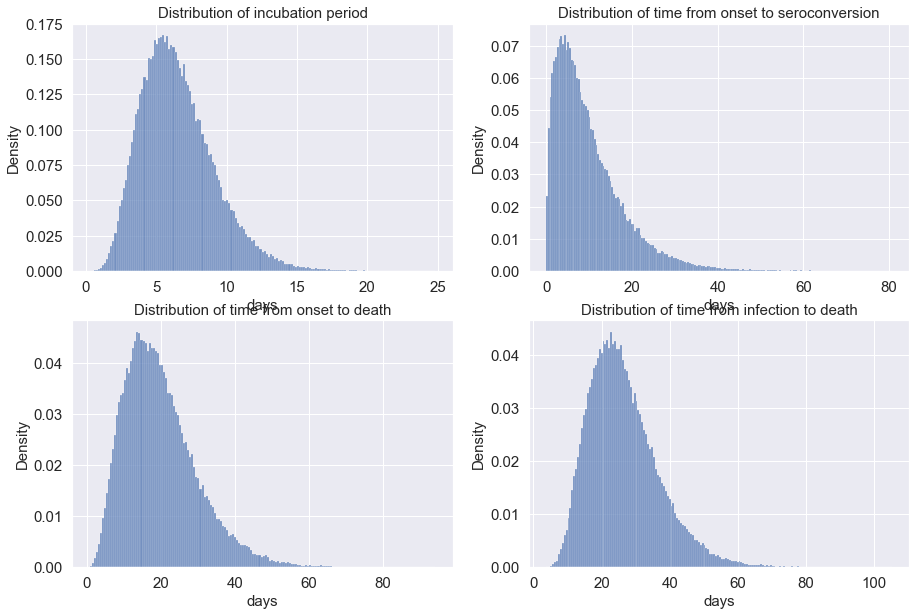

In [42]:
N_samp=int(1e5)
fig, ax =plt.subplots(2,2)
incubationT = np.random.gamma((6.5/2.6)**2, 1/(6.5/(2.6**2)), N_samp) # incubation period - Backer et al.
seroT = np.random.gamma((10/8)**2, 1/(10/(8**2)), N_samp) # onset to seroconversion - Lou et al.
onset_deathsT = np.random.gamma((20/10)**2, 1/(20/(10**2)), N_samp) # onset to seroconversion - Lou et al.
infection_deathsT=incubationT+onset_deathsT # infection to deaths

sns.histplot(incubationT, stat='density', ax=ax[0,0])
sns.histplot(seroT, stat='density', ax=ax[0,1])
sns.histplot(onset_deathsT, stat='density', ax=ax[1,0])
sns.histplot(infection_deathsT, stat='density', ax=ax[1,1])

ax[0,0].set_title('Distribution of incubation period')
ax[0,1].set_title('Distribution of time from onset to seroconversion')
ax[1,0].set_title('Distribution of time from onset to death')
ax[1,1].set_title('Distribution of time from infection to death')
ax[0,0].set_xlabel('days')
ax[0,1].set_xlabel('days')
ax[1,0].set_xlabel('days')
ax[1,1].set_xlabel('days')

In [43]:
def onset(ddeathsAll, delay, N_day_raw):
    deathsTonset_raw=np.zeros((N_day_raw,N_area))
    N_day=N_day_raw-delay; # number of deaths since the begining of pandemia we can estimate infected from deaths (deaths of today are the infected of 20 days ago in average)
    deathsTonset=np.zeros((N_day,N_area))
    for c in range(N_area):
        for i in range(N_day_raw):
            if(ddeathsAll[i,c]>0):
                for k in range(ddeathsAll[i,c]):
                    di = int(np.floor(onset_deathsT[int(np.floor(np.random.uniform(0,ddeathsAll.shape[0]+1)))]))
                    if((i-di)<1):
                        deathsTonset_raw[0,c] = deathsTonset_raw[0,c]+1
                    else:
                        deathsTonset_raw[(i-di),c] += 1

        deathsTonset[:,c] = np.cumsum(deathsTonset_raw[:-delay,c])
    return deathsTonset.astype(int)

In [44]:
def infec(ddeathsAll, delay, N_day_raw):
    deathsTinfec_raw=np.zeros((N_day_raw,N_area))
    N_day=N_day_raw-delay; # number of deaths since the begining of pandemia we can estimate infected from deaths (deaths of today are the infected of 20 days ago in average)
    deathsTinfec=np.zeros((N_day,N_area))
    for c in range(N_area):
        for i in range(N_day_raw):
            if(ddeathsAll[i,c]>0):
                for k in range(ddeathsAll[i,c]):
                    di = int(np.floor(infection_deathsT[int(np.floor(np.random.uniform(0,ddeathsAll.shape[0]+1)))]))
                    if((i-di)<1):
                        deathsTinfec_raw[0,c] = deathsTinfec_raw[0,c]+1
                    else:
                        deathsTinfec_raw[(i-di),c] += 1

        deathsTinfec[:,c] = np.cumsum(deathsTinfec_raw[:-delay,c])
    return deathsTinfec.astype(int)

In [45]:
def sero(ddeathsAll, delay, N_day_raw):
    deathsTsero_raw=np.zeros((N_day_raw,N_area))
    N_day=N_day_raw-delay; # number of deaths since the begining of pandemia we can estimate infected from deaths (deaths of today are the infected of 20 days ago in average)
    deathsTsero=np.zeros((N_day,N_area))
    for c in range(N_area):
        for i in range(N_day_raw):
            if(ddeathsAll[i,c]>0):
                for k in range(ddeathsAll[i,c]):
                    od = int(np.floor(onset_deathsT[int(np.floor(np.random.uniform(0,ddeathsAll.shape[0]+1)))]))
                    os = int(np.floor(seroT[int(np.floor(np.random.uniform(0,ddeathsAll.shape[0]+1)))]))
                    if((i-od+os)<1):
                        deathsTsero_raw[0,c] = deathsTsero_raw[0,c]+1
                    elif((i-od+os)>=N_day_raw):
                        deathsTsero_raw[N_day,c] = deathsTsero_raw[N_day,c]+1
                    else:
                        deathsTsero_raw[(i-od+os),c] += 1

        deathsTsero[:,c] = np.cumsum(deathsTsero_raw[:-delay,c]).astype(int)
    return deathsTsero.astype(int)

In [46]:
delay=10;# mean delay between seroconversion to deaths

In [47]:
deathsTonsetAll = onset(ddeathsAll, delay, N_day)
deathsTinfecAll = infec(ddeathsAll, delay, N_day)
deathsTseroAll = sero(ddeathsAll, delay, N_day)

In [48]:
deathsTonsetConf = onset(ddeathsConf, delay, N_day)
deathsTinfecConf = infec(ddeathsConf, delay, N_day)
deathsTseroConf = sero(ddeathsConf, delay, N_day)

In [49]:
# relative attack rate by age
relativeProbInfec_baseline=np.ones(N_age)
relativeProbInfec_baseline[N_age-3:]=1
print('Relative infection attack rate by age:',relativeProbInfec_baseline)

Relative infection attack rate by age: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [50]:
#number of age-group 7 all age group, 6 lower than 80 years
N_age2=7;

In [51]:
relativeProbInfec2_baseline=np.array([1,1,1,1,1,1,1])
relativeProbInfec2_baseline=relativeProbInfec2_baseline[:N_age2]

In [52]:
# data hospitalisation
demo20=demo.loc[:,['Region','Sexo','Edad','a2020']].groupby(['Sexo','Edad','Region']).sum().reset_index()
N29=demo20[(demo20.Edad>= 18) & (demo20.Edad<= 29)].groupby('Sexo').sum().a2020.values
N39=demo20[(demo20.Edad>= 30) & (demo20.Edad<= 39)].groupby('Sexo').sum().a2020.values
N49=demo20[(demo20.Edad>= 30) & (demo20.Edad<= 49)].groupby('Sexo').sum().a2020.values
N=N29+N39+N49
date='2020-12-25'
h = hospi.loc[:,['Grupo de edad','Sexo',date]].dropna(axis=0)
# infection hospitalisation rate
h['probHospi']=np.array([0.2, 0.2, (0.6*N29[0]+ 1.2*N39[0]+ 1.6*N49[0])/N[1] ,3.2, 6.7, 11, 37.6, 0.1, 0.1, (0.5*N29[1]+0.9*N39[1]+1.3*N39[1])/N[1],2.6, 5.1, 7.8, 19.3])*1e-2
h['probHospiLow']=np.array([0.08, 0.08, (0.3*N29[0]+ 0.7*N39[0]+ 0.9*N49[0])/N[1] ,1.8, 3.7, 6.2, 21.1,0.07, 0.07, (0.3*N29[1]+0.5*N39[1]+0.7*N39[1])/N[1],1.5, 2.9, 4.4, 10.9])*1e-2
h['probHospiUp']=np.array([0.2, 0.2, (0.9*N29[0]+ 1.9*N39[0]+ 2.6*N49[0])/N[1] ,5.2, 10.9, 17.9, 61.3,0.2, 0.2, (0.8*N29[1]+1.5*N39[1]+2.1*N39[1])/N[1],4.2, 8.3, 12.8, 31.6])*1e-2
# I changed a little bit the prior with respect to the source
h['probHospiLow']=np.array([0.08, 0.08, (0.3*N29[0]+ 0.7*N39[0]+ 0.9*N49[0])/N[1] ,1.8, 3.7, 6.2, 21.1,0.07, 0.07, (0.3*N29[1]+0.5*N39[1]+0.7*N39[1])/N[1],1.5, 2.9, 4.4, 10.9])*1e-2
h['probHospiUp']=np.array([0.4, 0.2, (0.9*N29[0]+ 1.9*N39[0]+ 2.6*N49[0])/N[1] ,5.2, 10.9, 17.9, 61.3,0.4, 0.2, (0.8*N29[1]+1.5*N39[1]+2.1*N39[1])/N[1],4.2, 8.3, 12.8, 31.6])*1e-2

h['infected']=h[date]/h['probHospi']
h['infectedUp']=h[date]/h['probHospiLow']
h['infectedLow']=h[date]/h['probHospiUp']

In [53]:
ihr_m=h[h.Sexo=='M'][['probHospiLow','probHospiUp']].values[:N_age2,:]
ihr_f=h[h.Sexo=='F'][['probHospiLow','probHospiUp']].values[:N_age2,:]

In [54]:
N_age2=ihr_m.shape[0]

In [55]:
hospi_m=h[h.Sexo=='M'][date].values[:N_age2].astype(int)
hospi_f=h[h.Sexo=='F'][date].values[:N_age2].astype(int)

In [56]:
ageInterval2=[0,5,18,50,60,70,80,130]

In [57]:
demo20
demo20['age-group2']=pd.cut(x=demo20['Edad'], bins=ageInterval2, right=False)

In [58]:
# population 2 for only chile
pop_m2=demo20[demo20.Sexo==1].groupby(['age-group2']).sum().a2020.values[:N_age2].astype(int)
pop_f2=demo20[demo20.Sexo==2].groupby(['age-group2']).sum().a2020.values[:N_age2].astype(int)

Stan model, see Stan User's Guide https://mc-stan.org/docs/2_25/stan-users-guide/index.html#overview

In [59]:
model = """
data {
    // Number of area where we compute prevalence
    int N_area;
    
    //Number of age group
    int N_age; // deaths age group
    int N_age2; // hospitalized age group
    
    // Population by 5 year age groups
    matrix[N_age,N_area] pop_m;
    matrix[N_age,N_area] pop_f;
    
    // Population age groups for hospitalized in Chile
    vector[N_age2] pop_m2;
    vector[N_age2] pop_f2;
  
    // Age-specific death data
    int deaths_m[N_age,N_area];
    int deaths_f[N_age,N_area];
    
    // Age-specific hospitalized data in Chile
    int hospi_m[N_age2];
    int hospi_f[N_age2];
    
    // IFR from article
    vector[N_age] ifr_m_lower;
    vector[N_age] ifr_m_upper;
    vector[N_age] ifr_f_lower;
    vector[N_age] ifr_f_upper;
    
    // IHR from article
    vector[N_age2] ihr_m_lower;
    vector[N_age2] ihr_m_upper;
    vector[N_age2] ihr_f_lower;
    vector[N_age2] ihr_f_upper;
    
    // Age-specific relative probabilities of infection
    real relativeProbInfec[N_age];
    // Age-specific relative probabilities of infection with hospitalized age structure
    real relativeProbInfec2[N_age2];
}

parameters {
    real <lower=0.01, upper=0.99> probInfec[N_area-1];
    vector <lower=0, upper=1>[N_age] ifr_m_raw;
    vector <lower=0, upper=1>[N_age] ifr_f_raw;
    vector <lower=0, upper=1>[N_age2] ihr_m_raw;
    vector <lower=0, upper=1>[N_age2] ihr_f_raw;

}
transformed parameters {

    vector[N_age] ifr_m_true = ifr_m_lower + (ifr_m_upper - ifr_m_lower) .* ifr_m_raw;
    vector[N_age] ifr_f_true = ifr_f_lower + (ifr_f_upper - ifr_f_lower) .* ifr_f_raw;
    
    vector[N_age2] ihr_m_true = ihr_m_lower + (ihr_m_upper - ihr_m_lower) .* ihr_m_raw;
    vector[N_age2] ihr_f_true = ihr_f_lower + (ihr_f_upper - ihr_f_lower) .* ihr_f_raw;  
 
    real probInfecChile;
    probInfecChile =0;
    for (i in 1:(N_area-1)){
        probInfecChile = probInfecChile + probInfec[i] * sum(pop_m[,i]+pop_f[,i])/sum(pop_m[,17]+pop_f[,17]);
    }

    
}

model {

    // Priors
    probInfec ~ uniform(0.01,0.99);
    for (a in 1:N_age){
        ifr_m_raw[a]~uniform(0,1);
        ifr_f_raw[a]~uniform(0,1);
    }
    for (a in 1:N_age2){
        ihr_m_raw[a]~uniform(0,1);
        ihr_f_raw[a]~uniform(0,1);
    }
    
    for (a in 1:N_age){
        for (i in 1:(N_area-1)){
            deaths_m[a,i] ~ poisson(pop_m[a,i]*probInfec[i]*relativeProbInfec[a]*ifr_m_true[a]);
            deaths_f[a,i] ~ poisson(pop_f[a,i]*probInfec[i]*relativeProbInfec[a]*ifr_f_true[a]);
        }
    }
    
    for (a in 1:N_age2){
        hospi_m[a] ~ poisson(pop_m2[a]*probInfecChile*relativeProbInfec2[a]*ihr_m_true[a]);
        hospi_f[a] ~ poisson(pop_f2[a]*probInfecChile*relativeProbInfec2[a]*ihr_f_true[a]);
    }

}

generated quantities {
  
    real ifr_C[N_area]; 
    real ifr[N_age];
    int deaths_m_predicted[N_age,N_area];
    int deaths_f_predicted[N_age,N_area];

    real ihr[N_age2];
    real ihr_chile;

    // posterior IFR
    for(a in 1:N_age) ifr[a] = (ifr_m_true[a]+ifr_f_true[a])/2;
    
    // posterior IHR
    for(a in 1:N_age2) ihr[a] = (ihr_m_true[a]+ihr_f_true[a])/2;

      
    // Population-weighted IFRs
    for(c in 1:N_area){
        ifr_C[c] = sum(to_vector(ifr_m_true).*to_vector(pop_m[,c]) + to_vector(ifr_f_true).*to_vector(pop_f[,c]))/sum(pop_m[,c]+pop_f[,c]);
    }
    
    ihr_chile = (dot_product(ihr_m_true,pop_m2)+dot_product(ihr_f_true,pop_f2))/sum(pop_m2+pop_f2);
    
    // Number of deaths predicted
    for (a in 1:N_age){
        for (i in 1:(N_area-1)){
            deaths_m_predicted[a,i] = poisson_rng(pop_m[a,i]*probInfec[i]*ifr_m_true[a]*relativeProbInfec[a]);
            deaths_f_predicted[a,i] = poisson_rng(pop_f[a,i]*probInfec[i]*ifr_f_true[a]*relativeProbInfec[a]);
        }
        deaths_m_predicted[a,17] = poisson_rng(pop_m[a,17]*probInfecChile*ifr_m_true[a]*relativeProbInfec[a]);
        deaths_f_predicted[a,17] = poisson_rng(pop_f[a,17]*probInfecChile*ifr_f_true[a]*relativeProbInfec[a]);
    }

}

"""

In [60]:
# Compile the model
sm = ps.StanModel(model_code=model) #UNCOMMENT TO COMPILE IN C++

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_348b98b7a3b9d2bf1d9c8ca27ab848ac NOW.


In [61]:
# Initialisation with all deaths
data = {'N_age':pop_m_region.shape[0],'N_area':pop_m_region.shape[1],'pop_m':pop_m_region , 'pop_f': pop_f_region, 
            'deaths_m':deaths_m_regionAll, 'deaths_f':deaths_f_regionAll, 'ifr_m_lower':ifr_m[:,0],'ifr_m_upper':ifr_m[:,1],
            'ifr_f_lower':ifr_f[:,0],'ifr_f_upper':ifr_f[:,1], 'relativeProbInfec':relativeProbInfec_baseline,
       'N_age2':N_age2, 'pop_m2':pop_m2, 'pop_f2':pop_f2, 'hospi_m':hospi_m, 'hospi_f':hospi_f, 'ihr_m_lower':ihr_m[:,0],'ihr_m_upper':ihr_m[:,1],
       'ihr_f_lower':ihr_f[:,0],'ihr_f_upper':ihr_f[:,1], 'relativeProbInfec2':relativeProbInfec2_baseline}

In [62]:
# Initialisation with pcr covid-19 confirmed deaths
dataConf = {'N_age':pop_m_region.shape[0],'N_area':pop_m_region.shape[1],'pop_m':pop_m_region , 'pop_f': pop_f_region, 
            'deaths_m':deaths_m_regionConf, 'deaths_f':deaths_f_regionConf, 'ifr_m_lower':ifr_m[:,0],'ifr_m_upper':ifr_m[:,1],
            'ifr_f_lower':ifr_f[:,0],'ifr_f_upper':ifr_f[:,1], 'relativeProbInfec':relativeProbInfec_baseline,
            'N_age2':N_age2, 'pop_m2':pop_m2, 'pop_f2':pop_f2, 'hospi_m':hospi_m, 'hospi_f':hospi_f, 'ihr_m_lower':ihr_m[:,0],'ihr_m_upper':ihr_m[:,1],
           'ihr_f_lower':ihr_f[:,0],'ihr_f_upper':ihr_f[:,1], 'relativeProbInfec2':relativeProbInfec2_baseline}

In [63]:
# Sampling of the MCMC with all deaths
fit = sm.sampling(data=data, iter=10000, chains=4, warmup=5000, thin=1, seed=101, n_jobs=4, init_r=2)

In [64]:
# Sampling of the MCMC with pcr confirmed deaths
fitConf = sm.sampling(data=dataConf, iter=10000, chains=4, warmup=5000, thin=1, seed=101, n_jobs=4, init_r=2)

In [65]:
#ps.check_hmc_diagnostics(fit)

In [66]:
print(fit.stansummary(pars=['probInfec','ifr_m_true','ifr_f_true','ihr_m_true','ihr_f_true','ifr','ihr'])) # UNCOMMENT TO SEE SUMMARY OF MODEL VARIABLES

Inference for Stan model: anon_model_348b98b7a3b9d2bf1d9c8ca27ab848ac.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                 mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
probInfec[1]     0.16  4.1e-5 8.6e-3   0.15   0.16   0.16   0.17    0.18  43734    1.0
probInfec[2]      0.2  3.6e-5 7.2e-3   0.19    0.2    0.2   0.21    0.22  39901    1.0
probInfec[3]     0.07  2.5e-5 5.5e-3   0.06   0.06   0.07   0.07    0.08  47382    1.0
probInfec[4]     0.06  1.4e-5 3.1e-3   0.06   0.06   0.06   0.07    0.07  47042    1.0
probInfec[5]     0.11  1.2e-5 2.5e-3    0.1   0.11   0.11   0.11    0.11  44270    1.0
probInfec[6]     0.11  1.7e-5 3.6e-3    0.1   0.11   0.11   0.11    0.12  43692    1.0
probInfec[7]     0.09  1.4e-5 3.0e-3   0.08   0.09   0.09   0.09    0.09  45501    1.0
probInfec[8]     0.09  1.2e-5 2.6e-3   0.08   0.09   0.09   0.09    0.09  44362    1.0
probInfec[9]     0.07  1.3

## Posterior of IFRs

INFO:numba.core.transforms:finding looplift candidates


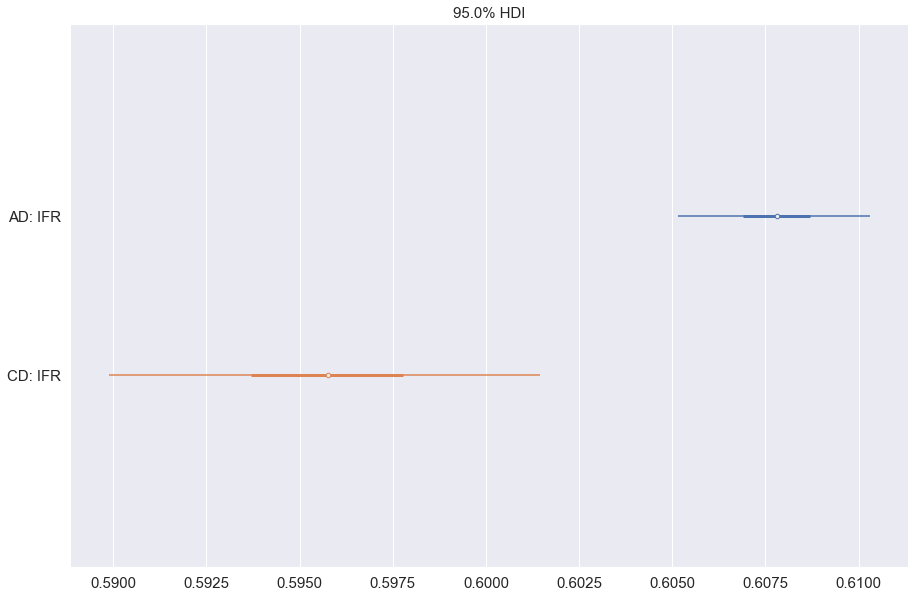

In [67]:
fig, ax=plt.subplots(1,figsize=(15,10))
az.plot_forest([{'IFR':fit.extract()['ifr_C'][:,16]*100}, {'IFR':fitConf.extract()['ifr_C'][:,16]*100}],
               model_names=["AD", "CD"],ax=ax, 
               hdi_prob=0.95)
fig.savefig('figures/ifr_chile.png')

In [68]:
ifr_prior=(ifr_m+ifr_f)/2

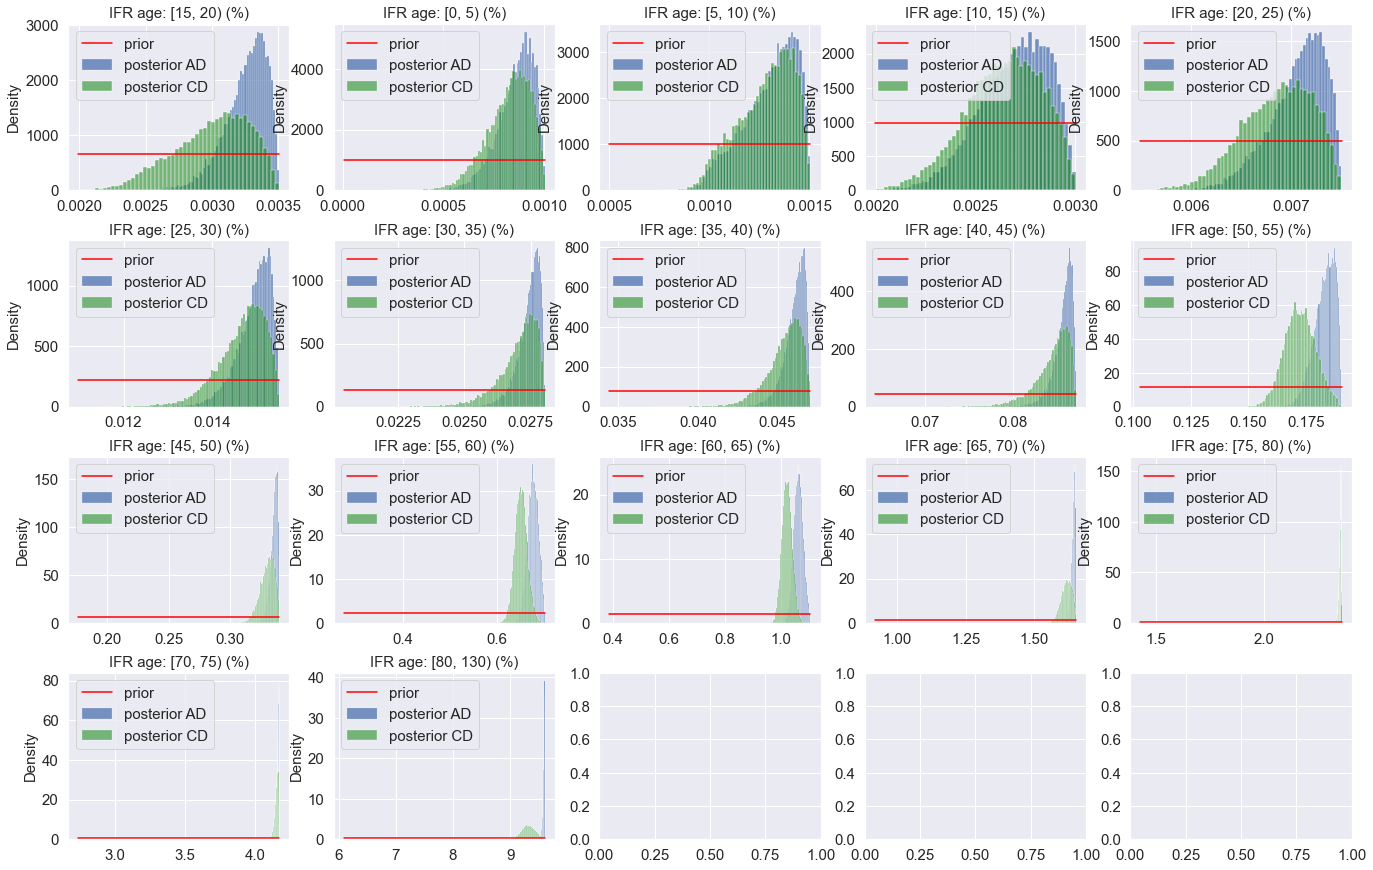

In [69]:
fig, ax =plt.subplots(4,5,figsize=(23,15))
for i in range(N_age):
    j=i//5
    k=i%5
    sns.histplot(fit.extract()['ifr'][:,i]*100, ax=ax[j,k], label='posterior AD', stat='density')
    sns.histplot(fitConf.extract()['ifr'][:,i]*100, ax=ax[j,k], label='posterior CD', stat='density', color='green', alpha=0.5)
    ax[j,k].plot(np.linspace(ifr_prior[i,0],ifr_prior[i,1],10)*100,1/((ifr_prior[i,1]-ifr_prior[i,0])*np.ones(10)*100),color='red', label='prior')
    ax[j,k].set_title(f'IFR age: {listAge[i]} (%)')
    ax[j,k].legend()
fig.subplots_adjust(hspace=0.3)
fig.savefig('figures/posterior_ifr.png')

INFO:numba.core.transforms:finding looplift candidates


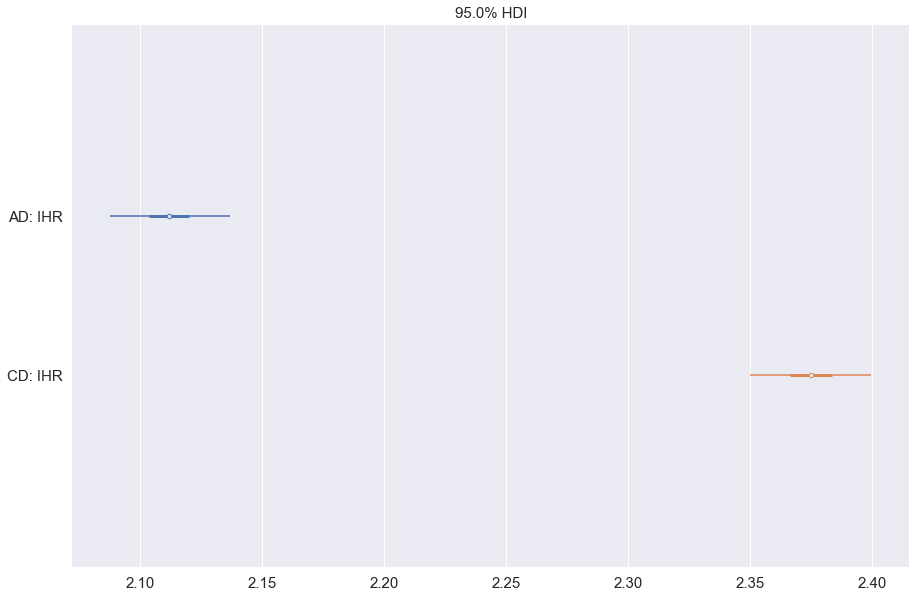

In [70]:
fig, ax=plt.subplots(1,figsize=(15,10))
az.plot_forest([{'IHR':fit.extract()['ihr_chile']*100}, {'IHR':fitConf.extract()['ihr_chile']*100}],
               model_names=["AD", "CD"],ax=ax, 
               hdi_prob=0.95)
fig.savefig('figures/ihr_chile.png')

In [71]:
listAge2=h['Grupo de edad'].unique()

In [72]:
ihr_prior=(ihr_m+ihr_f)/2

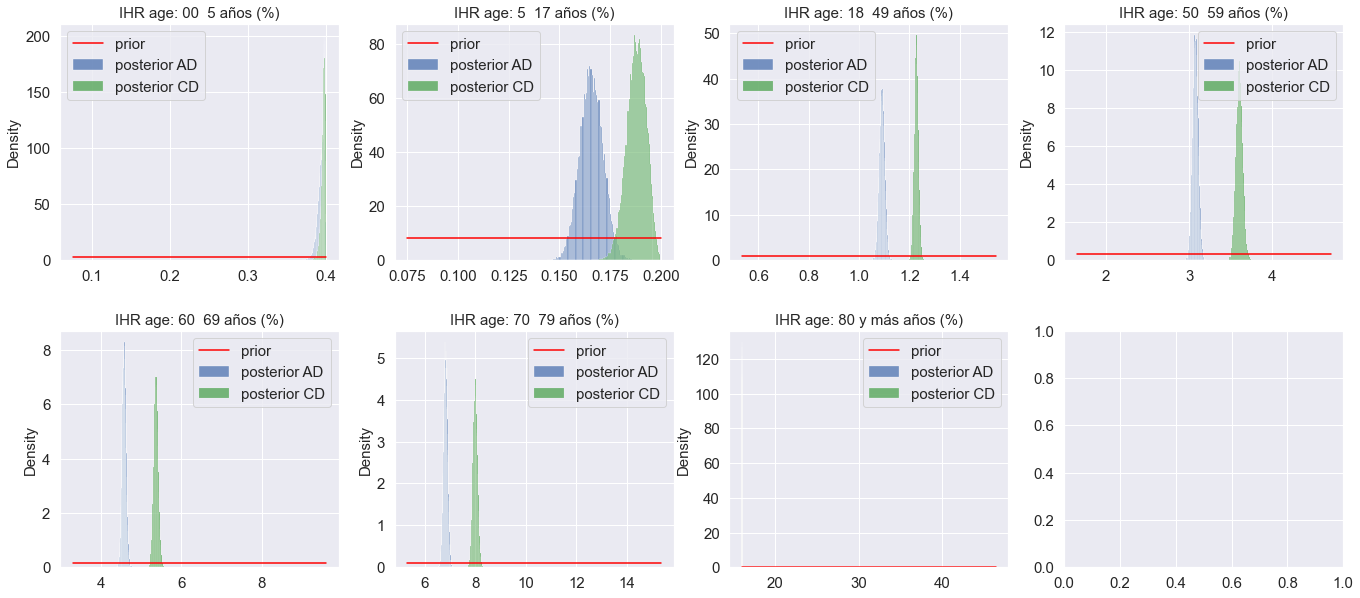

In [73]:
fig, ax =plt.subplots(2,4,figsize=(23,10))
for i in range(N_age2):
    j=i//4
    k=i%4
    sns.histplot(fit.extract()['ihr'][:,i]*100, ax=ax[j,k], label='posterior AD', stat='density')
    sns.histplot(fitConf.extract()['ihr'][:,i]*100, ax=ax[j,k], label='posterior CD', stat='density', color='green', alpha=0.5)
    ax[j,k].plot(np.linspace(ihr_prior[i,0],ihr_prior[i,1],10)*100,1/((ihr_prior[i,1]-ihr_prior[i,0])*np.ones(10)*100),color='red', label='prior')
    ax[j,k].set_title(f'IHR age: {listAge2[i]} (%)')
    ax[j,k].legend()
fig.subplots_adjust(hspace=0.3)
fig.savefig('figures/posterior_ihr.png')

Text(0.5, 1.0, 'Median of IFR by age')

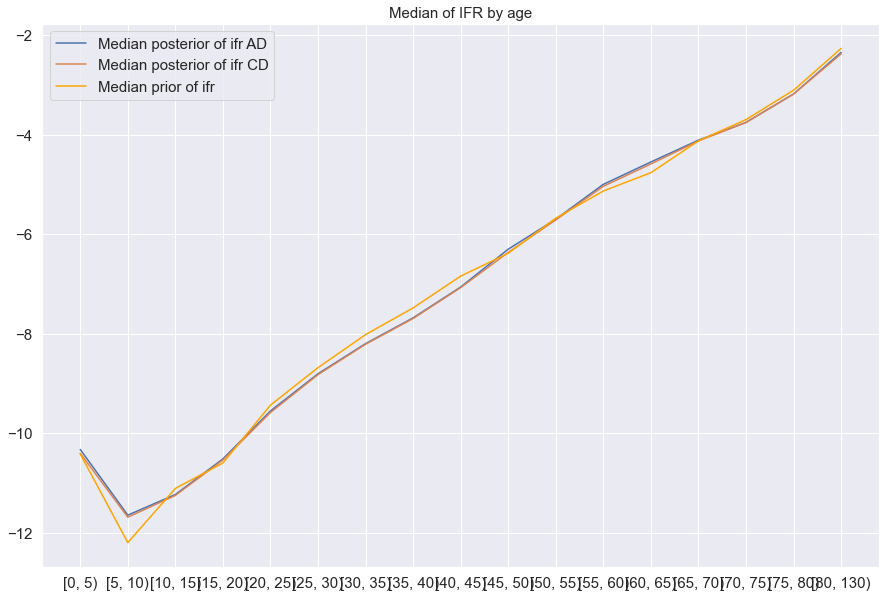

In [74]:
plt.plot(np.sort(deisAll['age-group'].unique()).astype(str)[:N_age],np.median(np.log(fit.extract()['ifr']),axis=0), label='Median posterior of ifr AD')
plt.plot(np.sort(deisAll['age-group'].unique()).astype(str)[:N_age],np.median(np.log(fitConf.extract()['ifr']),axis=0), label='Median posterior of ifr CD')
plt.plot(np.sort(deisAll['age-group'].unique()).astype(str)[:N_age],np.log((ifr['ifr_m'].values[:N_age]+ifr['ifr_f'].values[:N_age])/2), color='orange', label='Median prior of ifr')
plt.legend()
plt.title('Median of IFR by age')

## Posterior of seroprevalences

In [75]:
probInfec=np.concatenate((fit.extract()['probInfec'], np.array([fit.extract()['probInfecChile']]).T),axis=1)*100
probInfecConf=np.concatenate((fitConf.extract()['probInfec'], np.array([fitConf.extract()['probInfecChile']]).T),axis=1)*100

In [76]:
dicProbInfec={}
dicProbInfecConf={}
dicProbInfecMixed={}
for i in range(17):
    dicProbInfec[invDicRegion2[i+1]]=probInfec[:,i]
    dicProbInfecConf[invDicRegion2[i+1]]=probInfecConf[:,i]
    dicProbInfecMixed[invDicRegion2[i+1]]=np.concatenate((probInfec[:,i],probInfecConf[:,i]))

In [77]:
print(az.hdi(dicProbInfec).round(1).to_dataframe().T.to_latex())

\begin{tabular}{lrr}
\toprule
hdi &  lower &  higher \\
\midrule
Tarapacá           &   14.8 &    18.1 \\
Antofagasta        &   19.1 &    21.8 \\
Atacama            &    5.8 &     7.9 \\
Coquimbo           &    5.9 &     7.0 \\
Valparaíso         &   10.5 &    11.4 \\
O’Higgins          &   10.4 &    11.7 \\
Maule              &    8.3 &     9.4 \\
Biobío             &    8.3 &     9.2 \\
Araucanía          &    6.3 &     7.3 \\
Los Lagos          &    6.0 &     7.2 \\
Aysén              &    2.1 &     4.6 \\
Magallanes         &   19.9 &    24.5 \\
Metropolitana      &   23.8 &    24.6 \\
Los Ríos           &    4.2 &     5.7 \\
Arica y Parinacota &   14.8 &    18.4 \\
Ñuble              &    5.9 &     7.2 \\
Total              &   15.7 &    16.0 \\
\bottomrule
\end{tabular}



In [78]:
print(az.hdi(dicProbInfecConf).round(1).to_dataframe().T.to_latex())

\begin{tabular}{lrr}
\toprule
hdi &  lower &  higher \\
\midrule
Tarapacá           &   14.3 &    17.7 \\
Antofagasta        &   16.4 &    19.1 \\
Atacama            &    4.9 &     6.9 \\
Coquimbo           &    4.6 &     5.6 \\
Valparaíso         &    7.8 &     8.7 \\
O’Higgins          &    7.7 &     8.9 \\
Maule              &    6.8 &     7.9 \\
Biobío             &    7.1 &     8.0 \\
Araucanía          &    4.1 &     5.0 \\
Los Lagos          &    4.2 &     5.3 \\
Aysén              &    1.6 &     4.0 \\
Magallanes         &   17.0 &    21.5 \\
Metropolitana      &   20.9 &    21.5 \\
Los Ríos           &    3.2 &     4.5 \\
Arica y Parinacota &   13.0 &    16.5 \\
Ñuble              &    4.9 &     6.2 \\
Total              &   13.4 &    13.7 \\
\bottomrule
\end{tabular}



In [79]:
print(az.hdi(dicProbInfecMixed).round(1).to_dataframe().T.to_latex())

\begin{tabular}{lrr}
\toprule
hdi &  lower &  higher \\
\midrule
Tarapacá           &   14.6 &    18.0 \\
Antofagasta        &   16.6 &    21.5 \\
Atacama            &    5.1 &     7.7 \\
Coquimbo           &    4.7 &     6.9 \\
Valparaíso         &    7.9 &    11.3 \\
O’Higgins          &    7.8 &    11.6 \\
Maule              &    6.9 &     9.3 \\
Biobío             &    7.2 &     9.1 \\
Araucanía          &    4.1 &     7.2 \\
Los Lagos          &    4.3 &     7.1 \\
Aysén              &    1.8 &     4.4 \\
Magallanes         &   17.4 &    24.1 \\
Metropolitana      &   20.9 &    24.5 \\
Los Ríos           &    3.3 &     5.5 \\
Arica y Parinacota &   13.2 &    18.0 \\
Ñuble              &    5.0 &     7.1 \\
Total              &   13.4 &    16.0 \\
\bottomrule
\end{tabular}



INFO:numba.core.transforms:finding looplift candidates


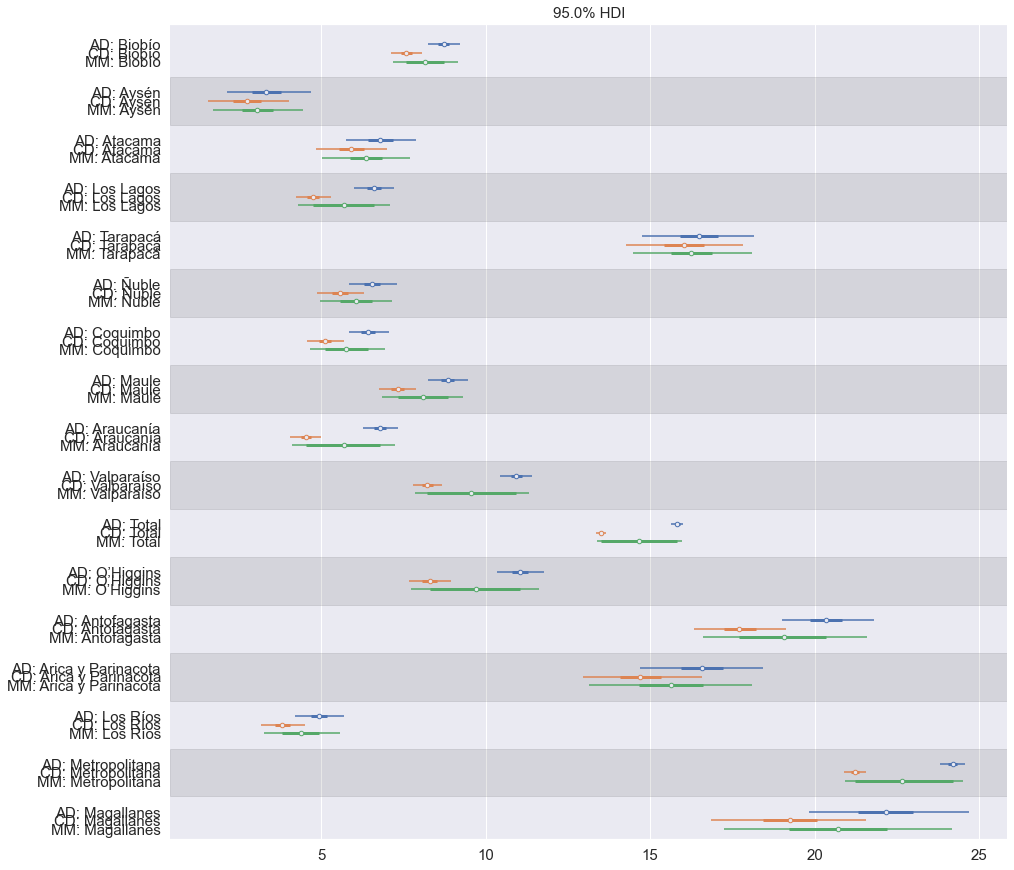

In [80]:
fig, ax=plt.subplots(1,figsize=(15,15))
az.plot_forest([dicProbInfec,dicProbInfecConf, dicProbInfecMixed], 
               model_names=["AD", 'CD', 'MM'],ax=ax, 
               hdi_prob=0.95, quartiles=True, combined=True, filter_vars='like')
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=15) 
fig.savefig('figures/plot_forest_sero.png')

In [81]:
def stats(sampling):
    #return median and credible interval 95%
    return np.array([np.quantile(sampling, 0.025, axis=0),np.quantile(sampling, 0.5, axis=0),np.quantile(sampling, 0.975, axis=0)]);

In [82]:
time_serie_sero=np.einsum('ij, kj->ikj', stats(probInfec)/deathsTAll, deathsTseroAll)
time_serie_onset=np.einsum('ij, kj->ikj', stats(probInfec)/deathsTAll, deathsTonsetAll)
time_serie_sero_conf=np.einsum('ij, kj->ikj', stats(probInfecConf)/deathsTConf, deathsTseroConf)
time_serie_onset_conf=np.einsum('ij, kj->ikj', stats(probInfecConf)/deathsTConf, deathsTonsetConf)

Text(0.5, 1.0, 'Seroprevalence in Chile (%)')

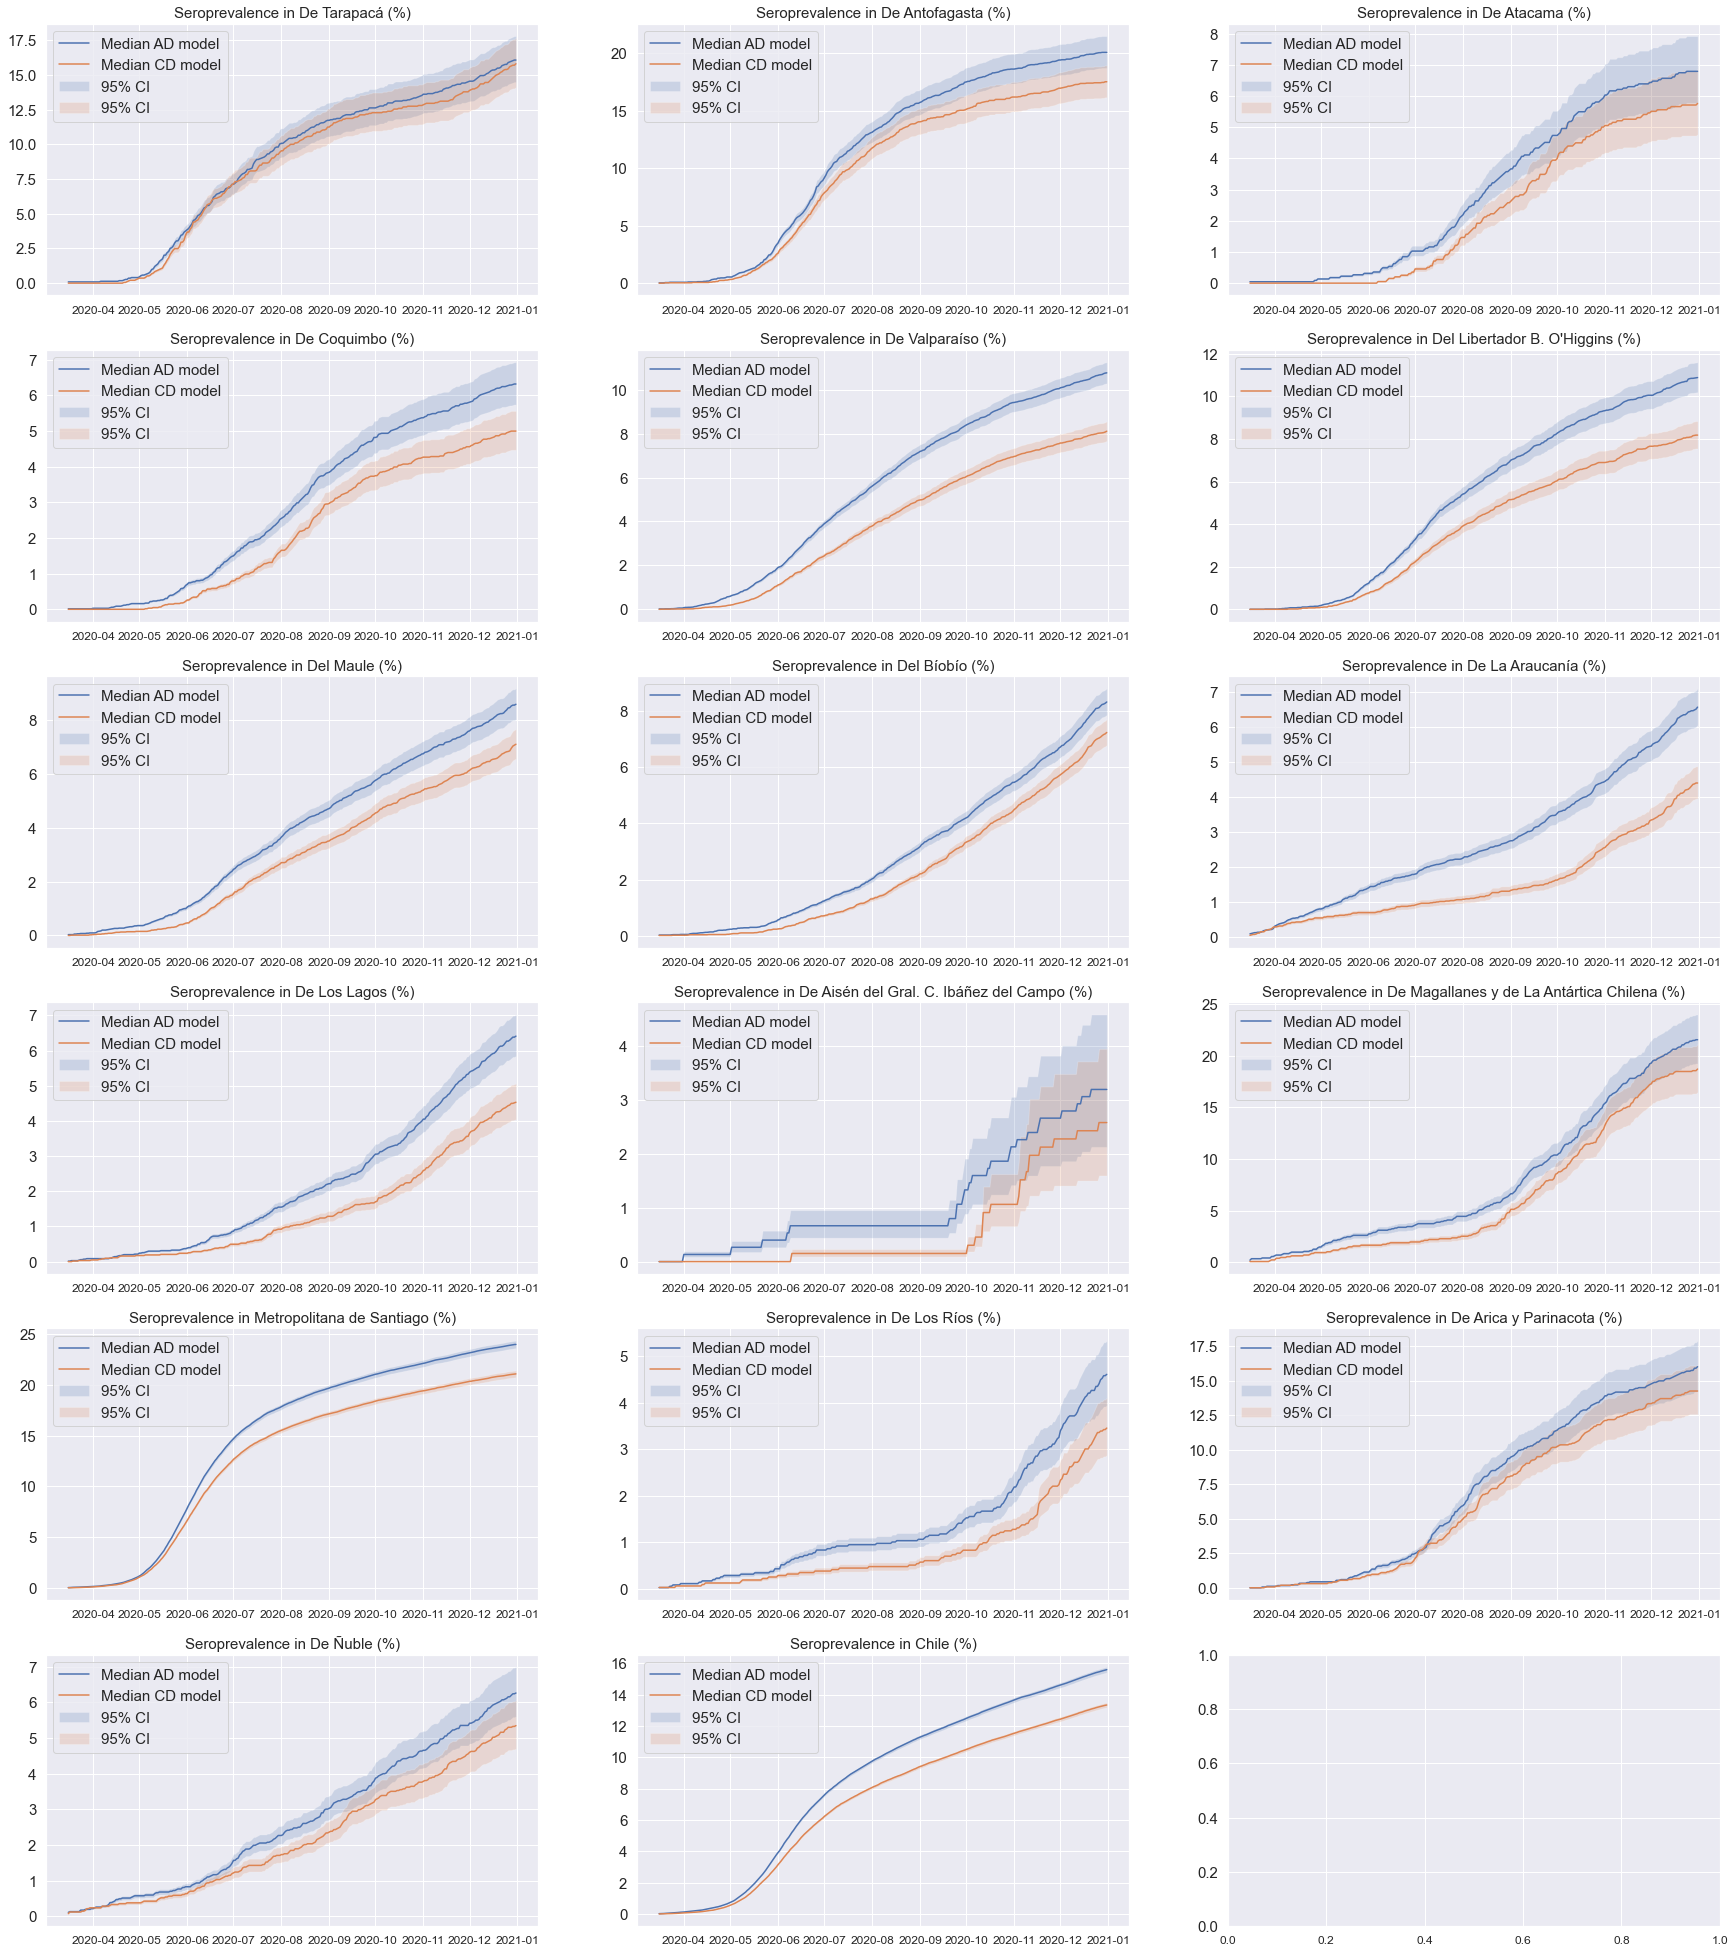

In [83]:
fig,ax=plt.subplots(6,3, figsize=(30,35))
for i in range(17):
    j=i//3;
    k=i%3
    ax[j,k].plot(timeFirstToLastDeath[:-delay],time_serie_sero[1,:,i], label='Median AD model')
    ax[j,k].fill_between(timeFirstToLastDeath[:-delay],time_serie_sero[0,:,i] ,time_serie_sero[2,:,i] , alpha=0.2, label='95% CI')
    ax[j,k].plot(timeFirstToLastDeath[:-delay],time_serie_sero_conf[1,:,i], label='Median CD model')
    ax[j,k].fill_between(timeFirstToLastDeath[:-delay],time_serie_sero_conf[0,:,i] ,time_serie_sero_conf[2,:,i] , alpha=0.2, label='95% CI')
    ax[j,k].set_title(f'Seroprevalence in {invDicRegion[i+1]} (%)')
    ax[j,k].legend()
ax[5,1].set_title(f'Seroprevalence in Chile (%)')


In [84]:
time_serie_sero_mixed=np.einsum('ij, kj->ikj', stats(np.concatenate((probInfec,probInfecConf)))/(deathsTConf), deathsTseroConf)

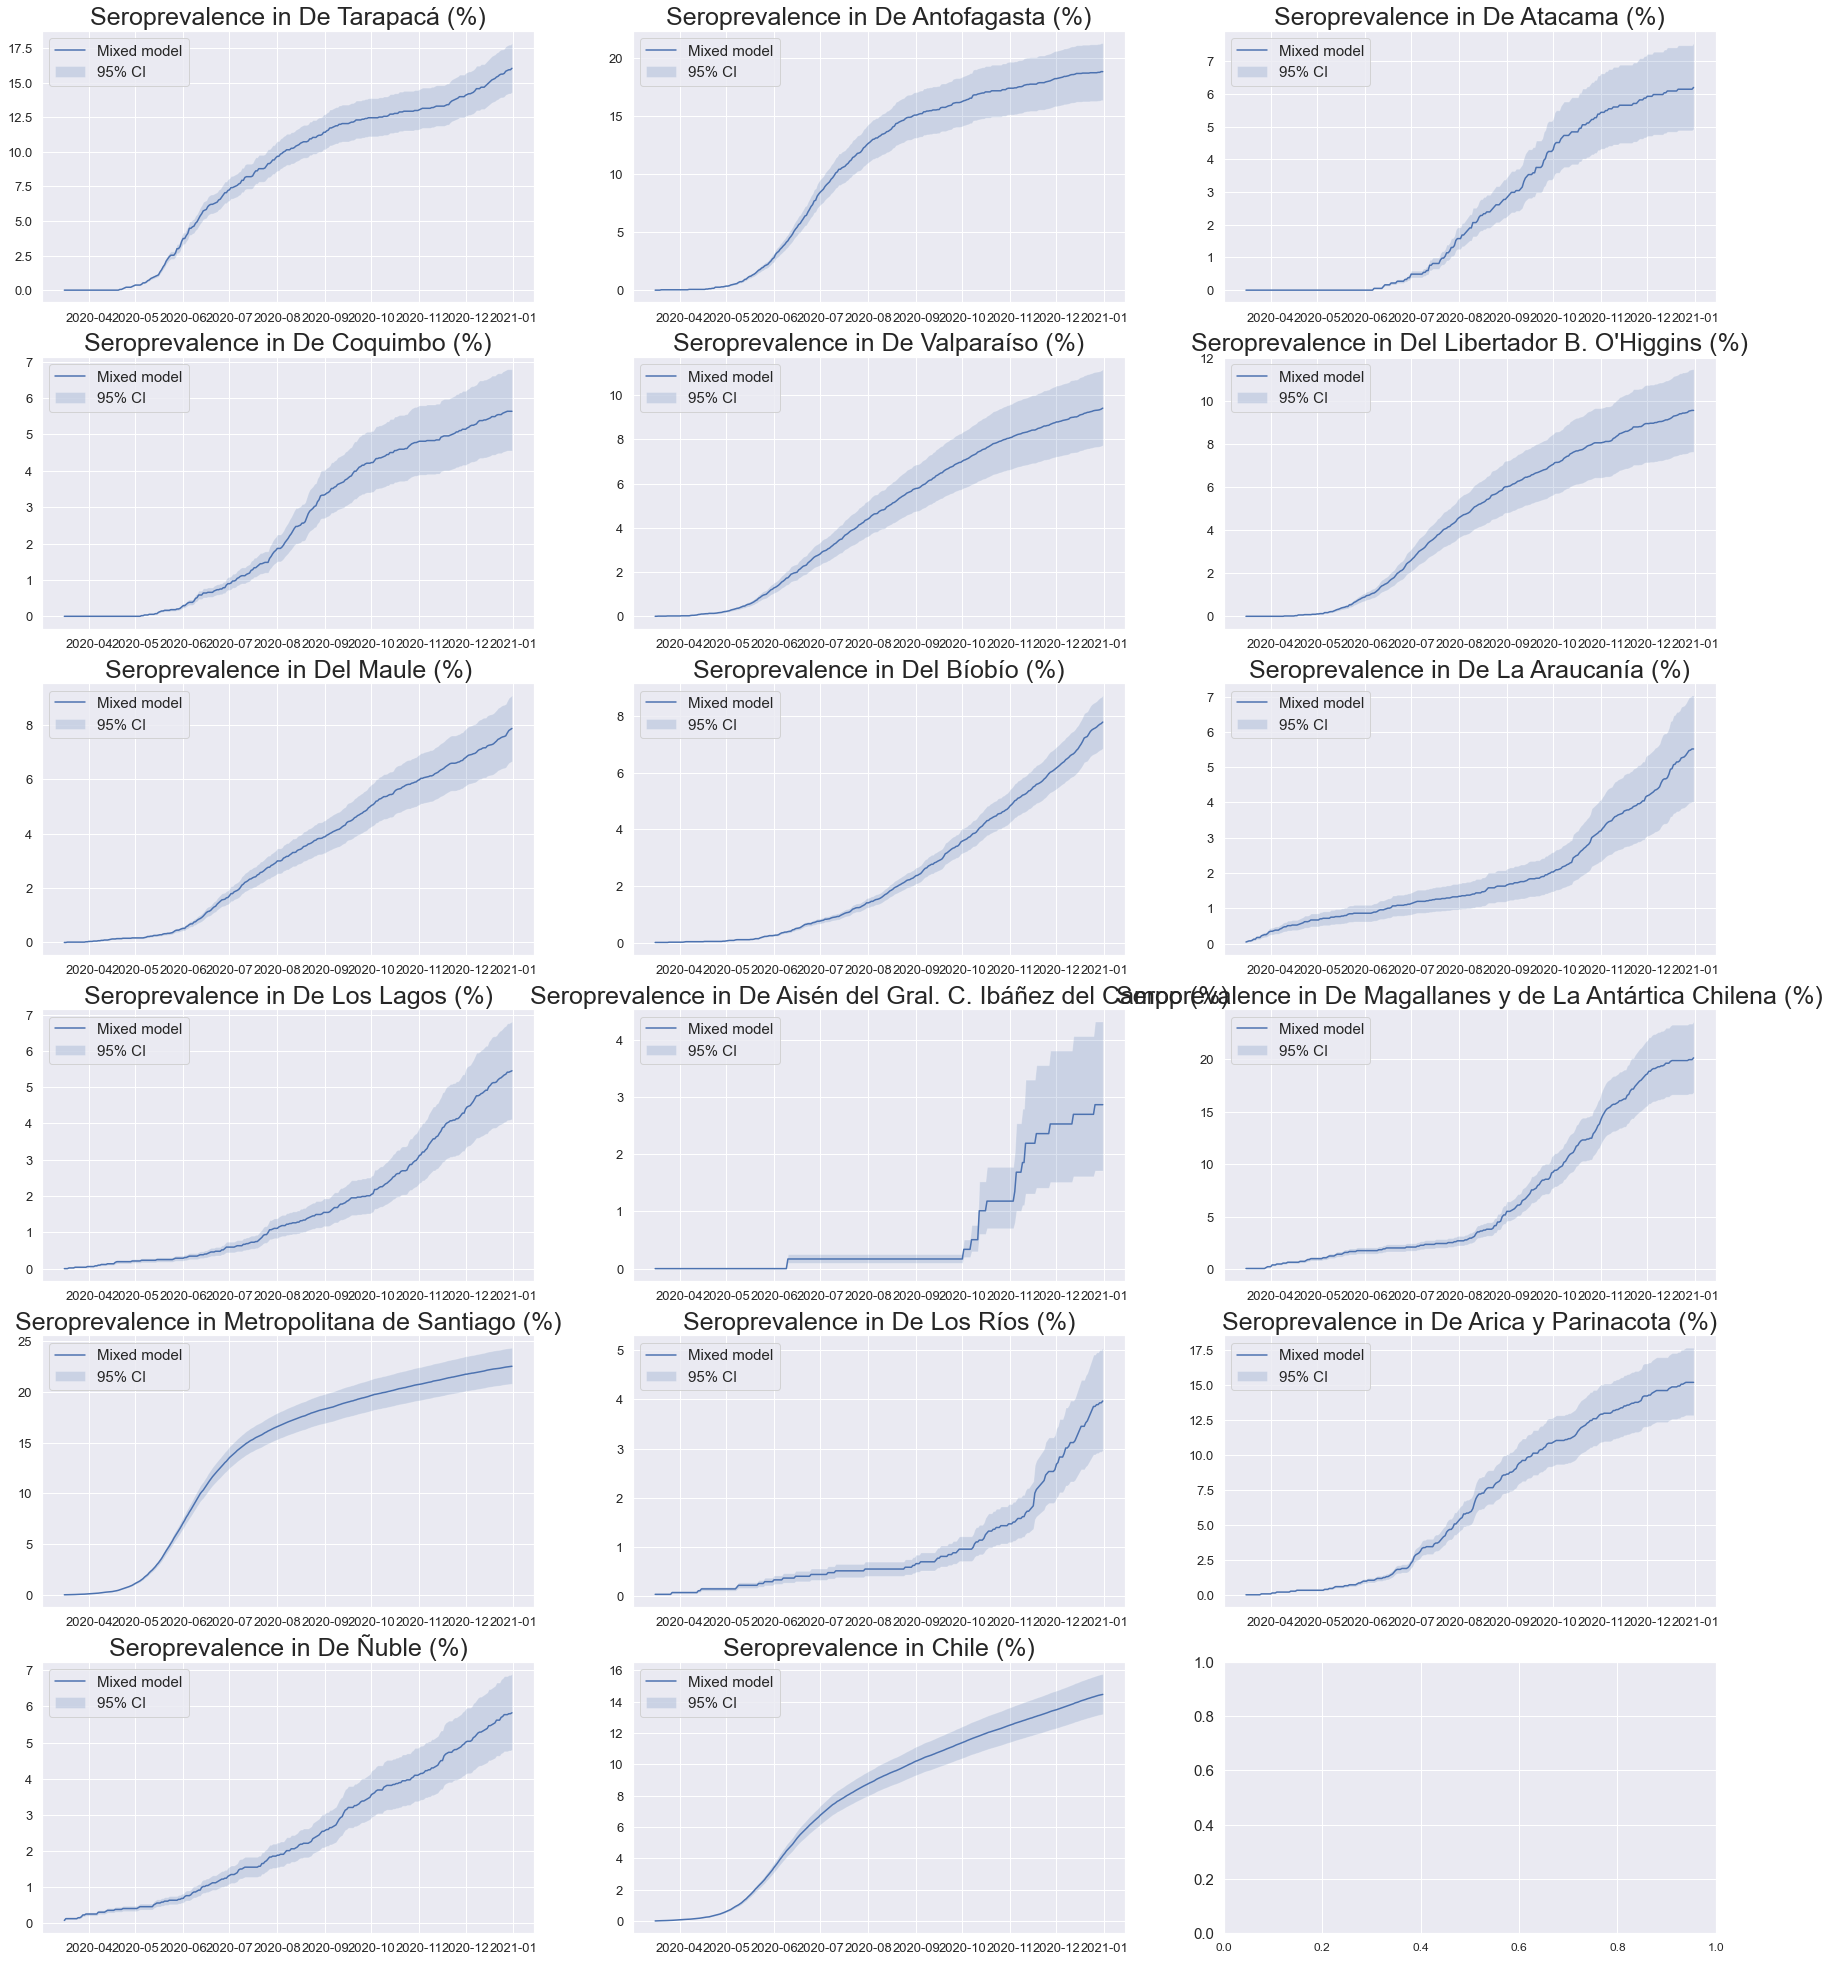

In [85]:
fig,ax=plt.subplots(6,3, figsize=(30,35))
for i in range(17):
    j=i//3;
    k=i%3
    ax[j,k].plot(timeFirstToLastDeath[:-delay],time_serie_sero_mixed[1,:,i], label='Mixed model')
    ax[j,k].fill_between(timeFirstToLastDeath[:-delay],time_serie_sero_mixed[0,:,i] ,time_serie_sero_mixed[2,:,i] , alpha=0.2, label='95% CI')
    ax[j,k].set_title(f'Seroprevalence in {invDicRegion[i+1]} (%)', fontsize=25)
    ax[j,k].legend(loc=2)
    ax[j,k].tick_params(axis='both', which='major', labelsize=13)
ax[5,1].tick_params(axis='both', which='major', labelsize=13)
ax[5,1].set_title(f'Seroprevalence in Chile (%)', fontsize=25)
fig.savefig('figures/time_series_seroprevalence_mixed.png')

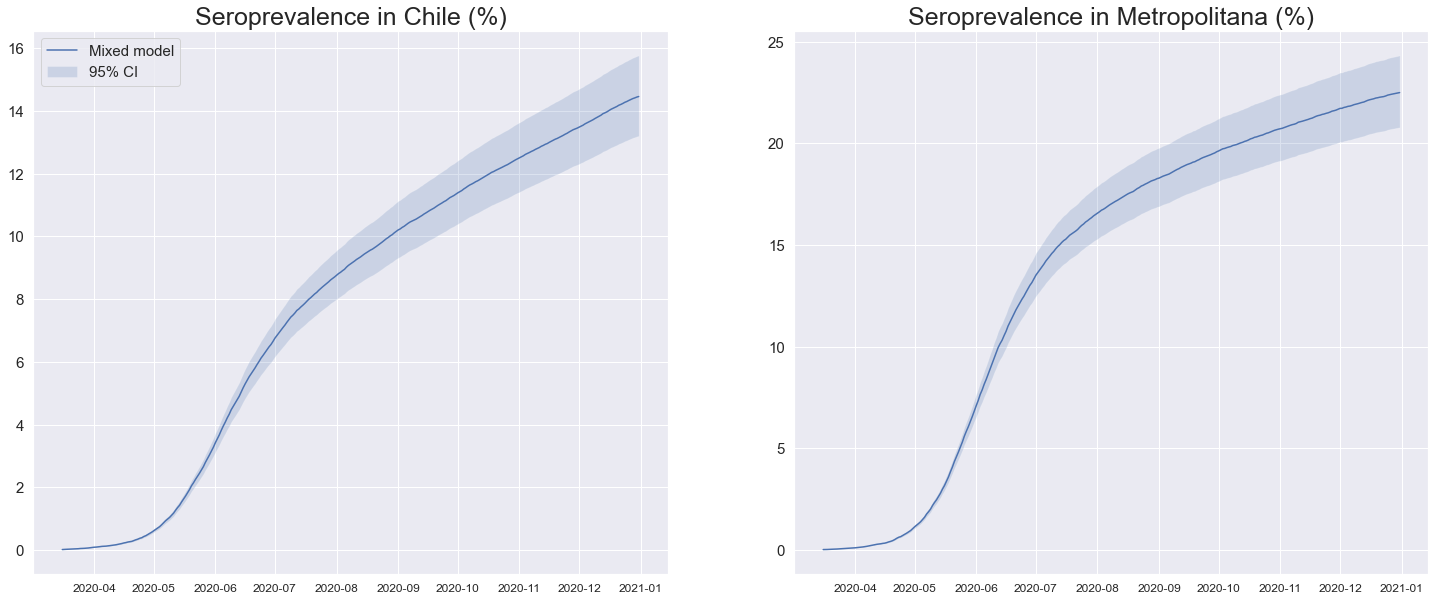

In [86]:
fig,ax=plt.subplots(1,2, figsize=(25,10))

ax[1].plot(timeFirstToLastDeath[:-delay],time_serie_sero_mixed[1,:,12], label='Mixed model')
ax[1].fill_between(timeFirstToLastDeath[:-delay],time_serie_sero_mixed[0,:,12] ,time_serie_sero_mixed[2,:,12] , alpha=0.2, label='95% CI')
ax[1].set_title(f'Seroprevalence in Metropolitana (%)', fontsize=25)
ax[0].plot(timeFirstToLastDeath[:-delay],time_serie_sero_mixed[1,:,16], label='Mixed model')
ax[0].fill_between(timeFirstToLastDeath[:-delay],time_serie_sero_mixed[0,:,16] ,time_serie_sero_mixed[2,:,16] , alpha=0.2, label='95% CI')
ax[0].legend(loc=2)
ax[0].set_title(f'Seroprevalence in Chile (%)', fontsize=25)

fig.savefig('figures/time_series_seroprevalence_mixed_chile_metro.png')

In [ ]:
seroChile = pd.DataFrame({'date':timeFirstToLastDeath[:-delay], 'propInfectedMedian':time_serie_sero_mixed[1,:,-1], 'propInfectedLB':time_serie_sero_mixed[0,:,-1],'propInfectedUB':time_serie_sero_mixed[2,:,-1]})

## The deaths observed and the deaths fitted by the model.

In [181]:
deaths_m_predictedConf=np.median(fitConf.extract()['deaths_m_predicted'],axis=0)
deaths_f_predictedConf=np.median(fitConf.extract()['deaths_f_predicted'],axis=0)

In [182]:
deaths_m_predicted=np.median(fit.extract()['deaths_m_predicted'],axis=0)
deaths_f_predicted=np.median(fit.extract()['deaths_f_predicted'],axis=0)

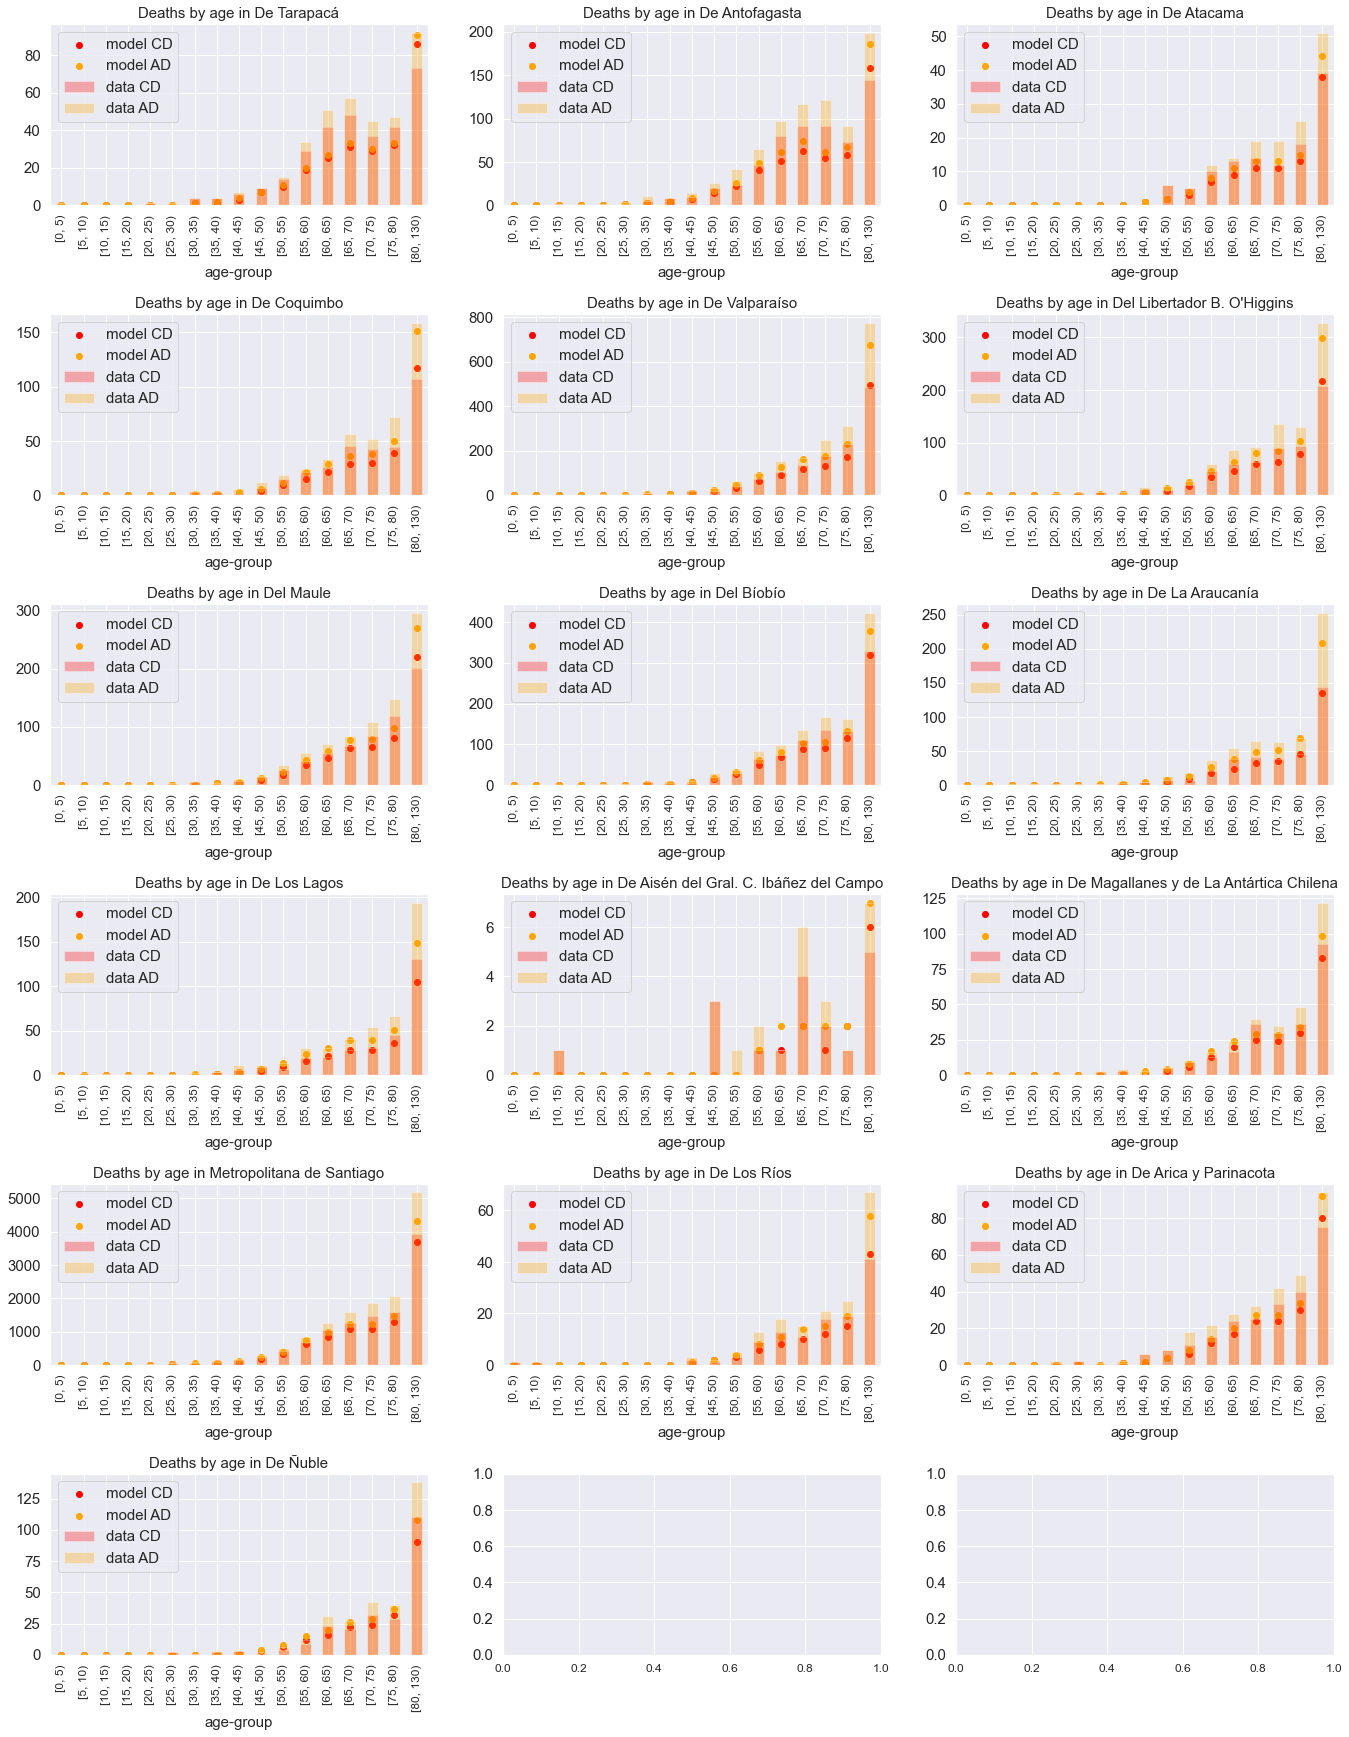

In [206]:
fig, ax =plt.subplots(6,3,figsize=(23,30))
for i in range(0,N_area-1):
    j=i//3
    k=i%3
    ax[j,k].scatter(range(N_age),deaths_m_predictedConf[:,i]+deaths_f_predictedConf[:,i],  color='red', label='model CD')
    deisAll[(deisAll['cause']=='confirmed')&(deisAll.region==i+1)].groupby(['age-group','region']).count().reset_index().plot.bar(x='age-group',y='date', label='data CD', ax=ax[j,k],alpha=0.3, color='red')
    ax[j,k].scatter(range(N_age),deaths_m_predicted[:,i]+deaths_f_predicted[:,i],  color='orange', label='model AD')    
    deisAll[(deisAll.region==i+1)].groupby(['age-group','region']).count().reset_index().plot.bar(x='age-group',y='date', label='data AD', ax=ax[j,k],alpha=0.3, color='orange')
    ax[j,k].set_title(f'Deaths by age in {invDicRegion[i+1]}')
    ax[j,k].legend()
#deisAll[deisAll['cause']=='confirmed'].groupby(['age-group']).count().reset_index().plot.bar(x='age-group',y='date', legend=False, ax=ax[5,1],alpha=0.5)
#ax[5,1].scatter(range(N_age),deaths_f_predicted[:,N_age-1]+deaths_m_predicted[:,N_age-1], label='Female', color='red')
#ax[5,1].set_title(f'Deaths by age Chile')
fig.subplots_adjust(hspace=0.6)
plt.savefig('figures/fit_deaths.png')

## Estimation of ratio  of cases detected

In [184]:
time_serie_onset_mixed=np.einsum('ij, kj->ikj', stats(np.concatenate((probInfec,probInfecConf)))/(deathsTConf), deathsTonsetConf)
time_serie_onset_mixed=time_serie_onset_mixed*((pop_m_region+pop_f_region).sum(axis=0))*1e-2

In [185]:
cases_chile=casos.T
cases_chile.columns=cases_chile.iloc[0,:]
cases_chile=cases_chile.iloc[1:,:]
cases_chile.index=pd.to_datetime(cases_chile.index, format='%Y-%m-%d')
cases_chile=cases_chile.diff().rolling(7).mean()

In [186]:
cases_estMixed=pd.DataFrame( time_serie_onset_mixed[1,:-30,:], index=timeFirstToLastDeath[:-delay-30])
cases_estMixed_low=pd.DataFrame( time_serie_onset_mixed[0,:-30,:], index=timeFirstToLastDeath[:-delay-30])
cases_estMixed_up=pd.DataFrame( time_serie_onset_mixed[2,:-30,:], index=timeFirstToLastDeath[:-delay-30])
cases_estMixed.index=pd.to_datetime(cases_estMixed.index, format='%Y-%m-%d')
cases_estMixed_low.index=pd.to_datetime(cases_estMixed_low.index, format='%Y-%m-%d')
cases_estMixed_up.index=pd.to_datetime(cases_estMixed_up.index, format='%Y-%m-%d')
cases_estMixed=cases_estMixed.diff().rolling(7).mean()
cases_estMixed_low=cases_estMixed_low.diff().rolling(7).mean()
cases_estMixed_up=cases_estMixed_up.diff().rolling(7).mean()

In [187]:
cases_estimated_september=pd.DataFrame([cases_estMixed_low[(cases_estMixed_low.index.month==9)].sum(), cases_estMixed[(cases_estMixed.index.month==9)].sum(), cases_estMixed_up[(cases_estMixed_up.index.month==9)].sum()]).T

In [188]:
cases_estimated_september=cases_estimated_september.rename(columns={0:'low',1:'median',2:'up'})

In [189]:
cases_estimated_september.index+=1

In [190]:
cases_estimated_september=cases_estimated_september.rename(invDicRegion2)

In [191]:
month=9 # month september

In [192]:
ratio_cases_det=cases_chile[(cases_chile.index.month==month)].sum().to_frame().div(cases_estimated_september['up'], axis=0).rename(columns={0:'low'})

In [193]:
ratio_cases_det['up']=cases_chile[(cases_chile.index.month==month)].sum().to_frame().div(cases_estimated_september['low'], axis=0)

In [194]:
ratio_cases_det['median']=cases_chile[(cases_chile.index.month==month)].sum().to_frame().div(cases_estimated_september['median'], axis=0)

In [195]:
ratio_cases_det

,low,up,median
Antofagasta,0.225351,0.293019,0.254815
Araucanía,0.282079,0.494160,0.359687
Arica y Parinacota,0.284691,0.391730,0.331166
Atacama,0.313764,0.480908,0.382469
Aysén,inf,inf,inf
Biobío,0.324255,0.412733,0.363512
Coquimbo,0.231902,0.345622,0.279481
Los Lagos,0.327305,0.540701,0.408823
Los Ríos,0.351728,0.599847,0.447878
Magallanes,0.567573,0.794801,0.665049


In [196]:
print(((ratio_cases_det.drop(columns='median').round(3)*100).round(2)).to_latex())

\begin{tabular}{lrr}
\toprule
{} &   low &    up \\
\midrule
Antofagasta        &  22.5 &  29.3 \\
Araucanía          &  28.2 &  49.4 \\
Arica y Parinacota &  28.5 &  39.2 \\
Atacama            &  31.4 &  48.1 \\
Aysén              &   inf &   inf \\
Biobío             &  32.4 &  41.3 \\
Coquimbo           &  23.2 &  34.6 \\
Los Lagos          &  32.7 &  54.1 \\
Los Ríos           &  35.2 &  60.0 \\
Magallanes         &  56.8 &  79.5 \\
Maule              &  26.8 &  36.5 \\
Metropolitana      &  12.2 &  14.2 \\
O’Higgins          &  21.1 &  31.7 \\
Tarapacá           &  25.3 &  31.6 \\
Total              &  20.3 &  24.2 \\
Valparaíso         &  15.8 &  22.8 \\
Ñuble              &  30.2 &  43.4 \\
\bottomrule
\end{tabular}



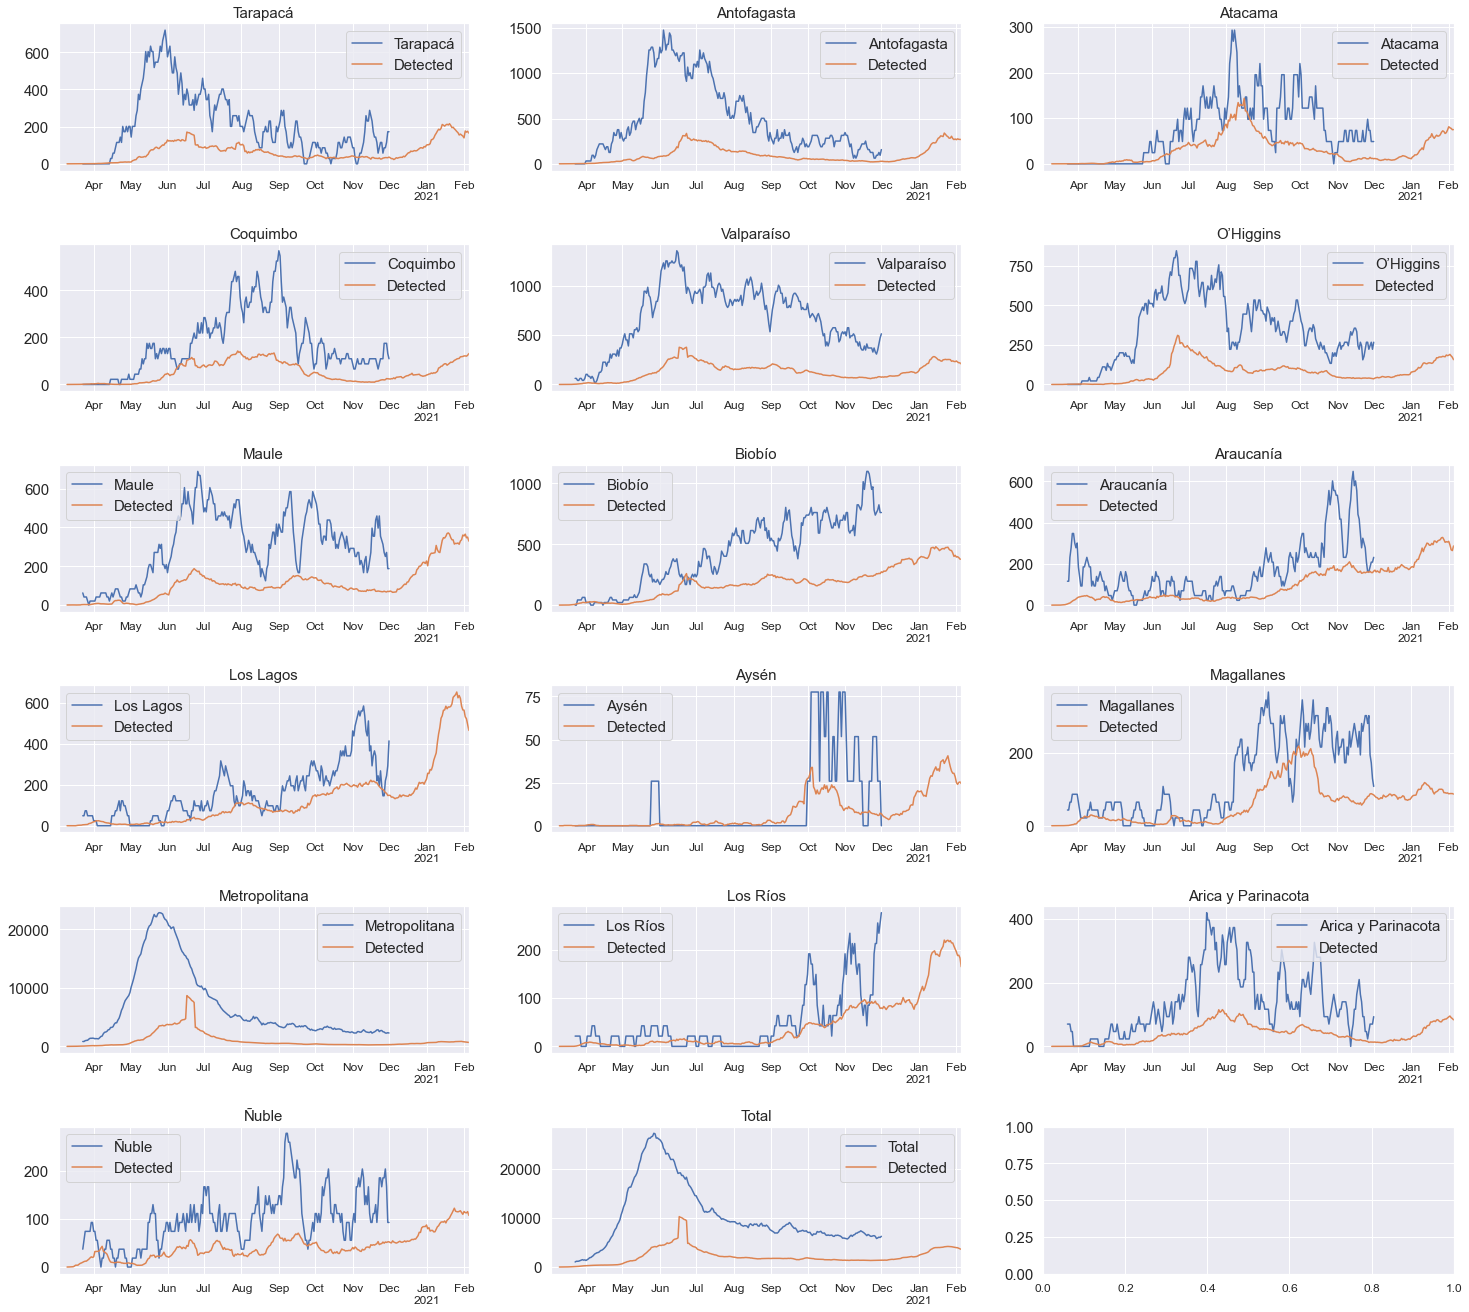

In [197]:
fig,ax=plt.subplots(6,3,figsize=(25,23))
for i in range(17):
    j=i//3;
    k=i%3
    cases_estMixed.plot(y=i, use_index=True, ax=ax[j,k], label=invDicRegion2[i+1])
    cases_chile.plot(y=invDicRegion2[i+1],use_index=True,ax=ax[j,k], label='Detected')
    ax[j,k].set_title(f'{invDicRegion2[i+1]}')
    ax[j,k].legend()
fig.subplots_adjust(hspace=0.5)
